In [1]:
pip install attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from attention import Attention
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, LSTM,Bidirectional
from pandas import read_csv
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv(
  "New_york.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [4]:
df.shape

(17356, 9)

In [5]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-01 00:00:00,16,0.24,0.2879,0.81,0.0,1,0,1,1
2017-01-01 01:00:00,40,0.22,0.2727,0.80,0.0,1,0,1,1
2017-01-01 02:00:00,32,0.22,0.2727,0.80,0.0,1,0,1,1
2017-01-01 03:00:00,13,0.24,0.2879,0.75,0.0,1,0,1,1
2017-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1,0,1,1


In [6]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

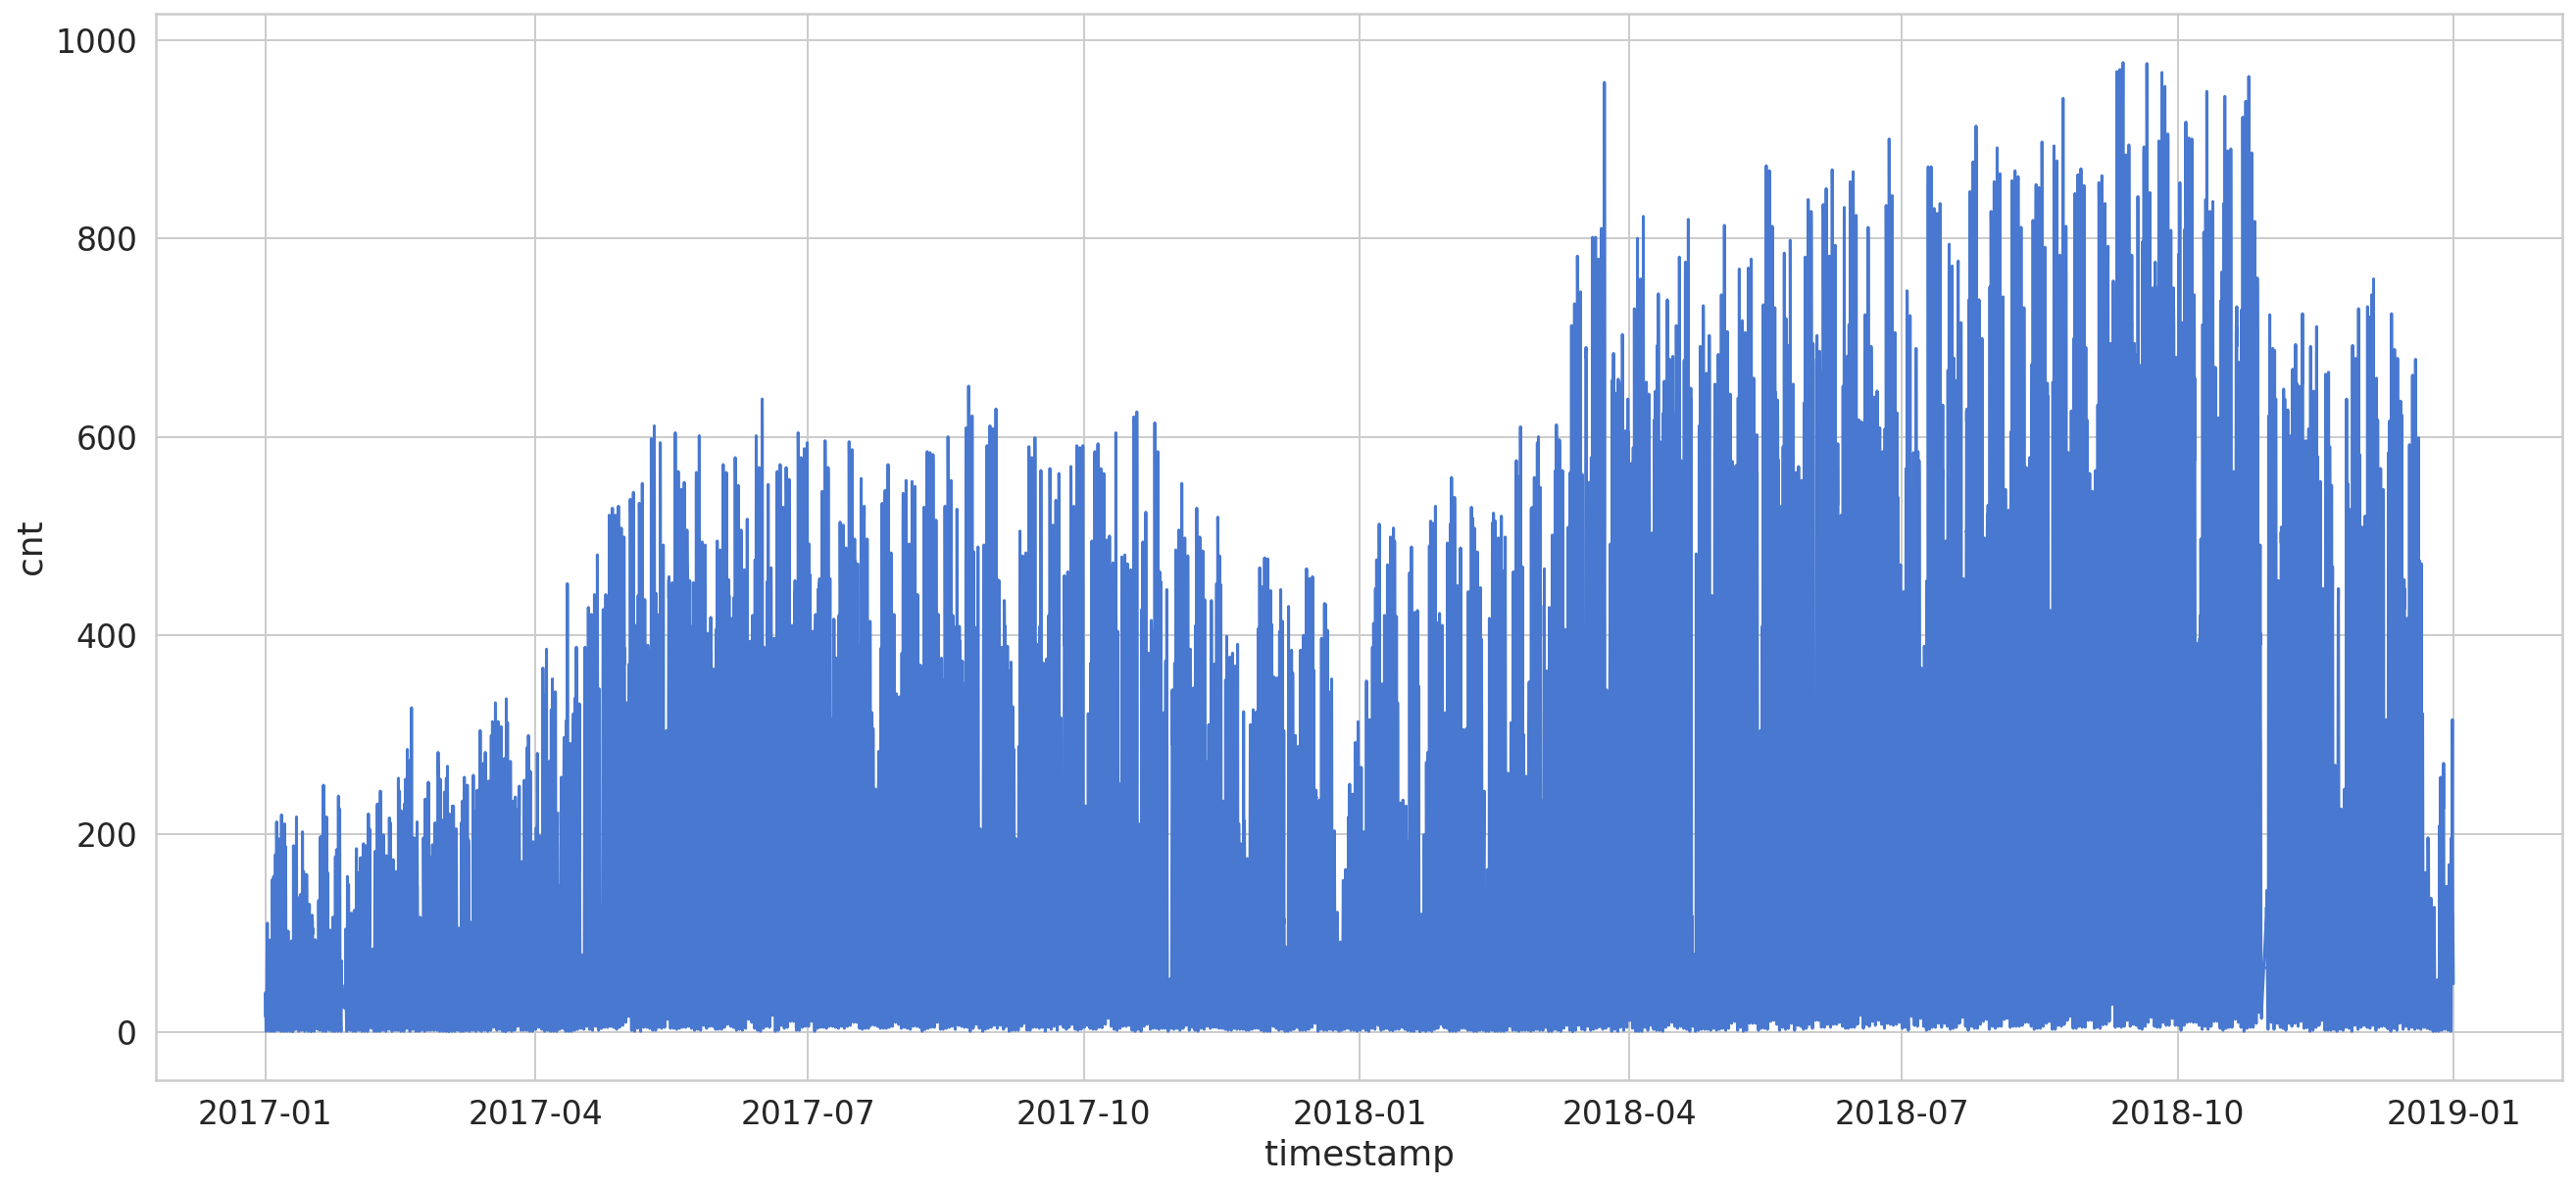

In [7]:
sns.lineplot(x=df.index, y="cnt", data=df);

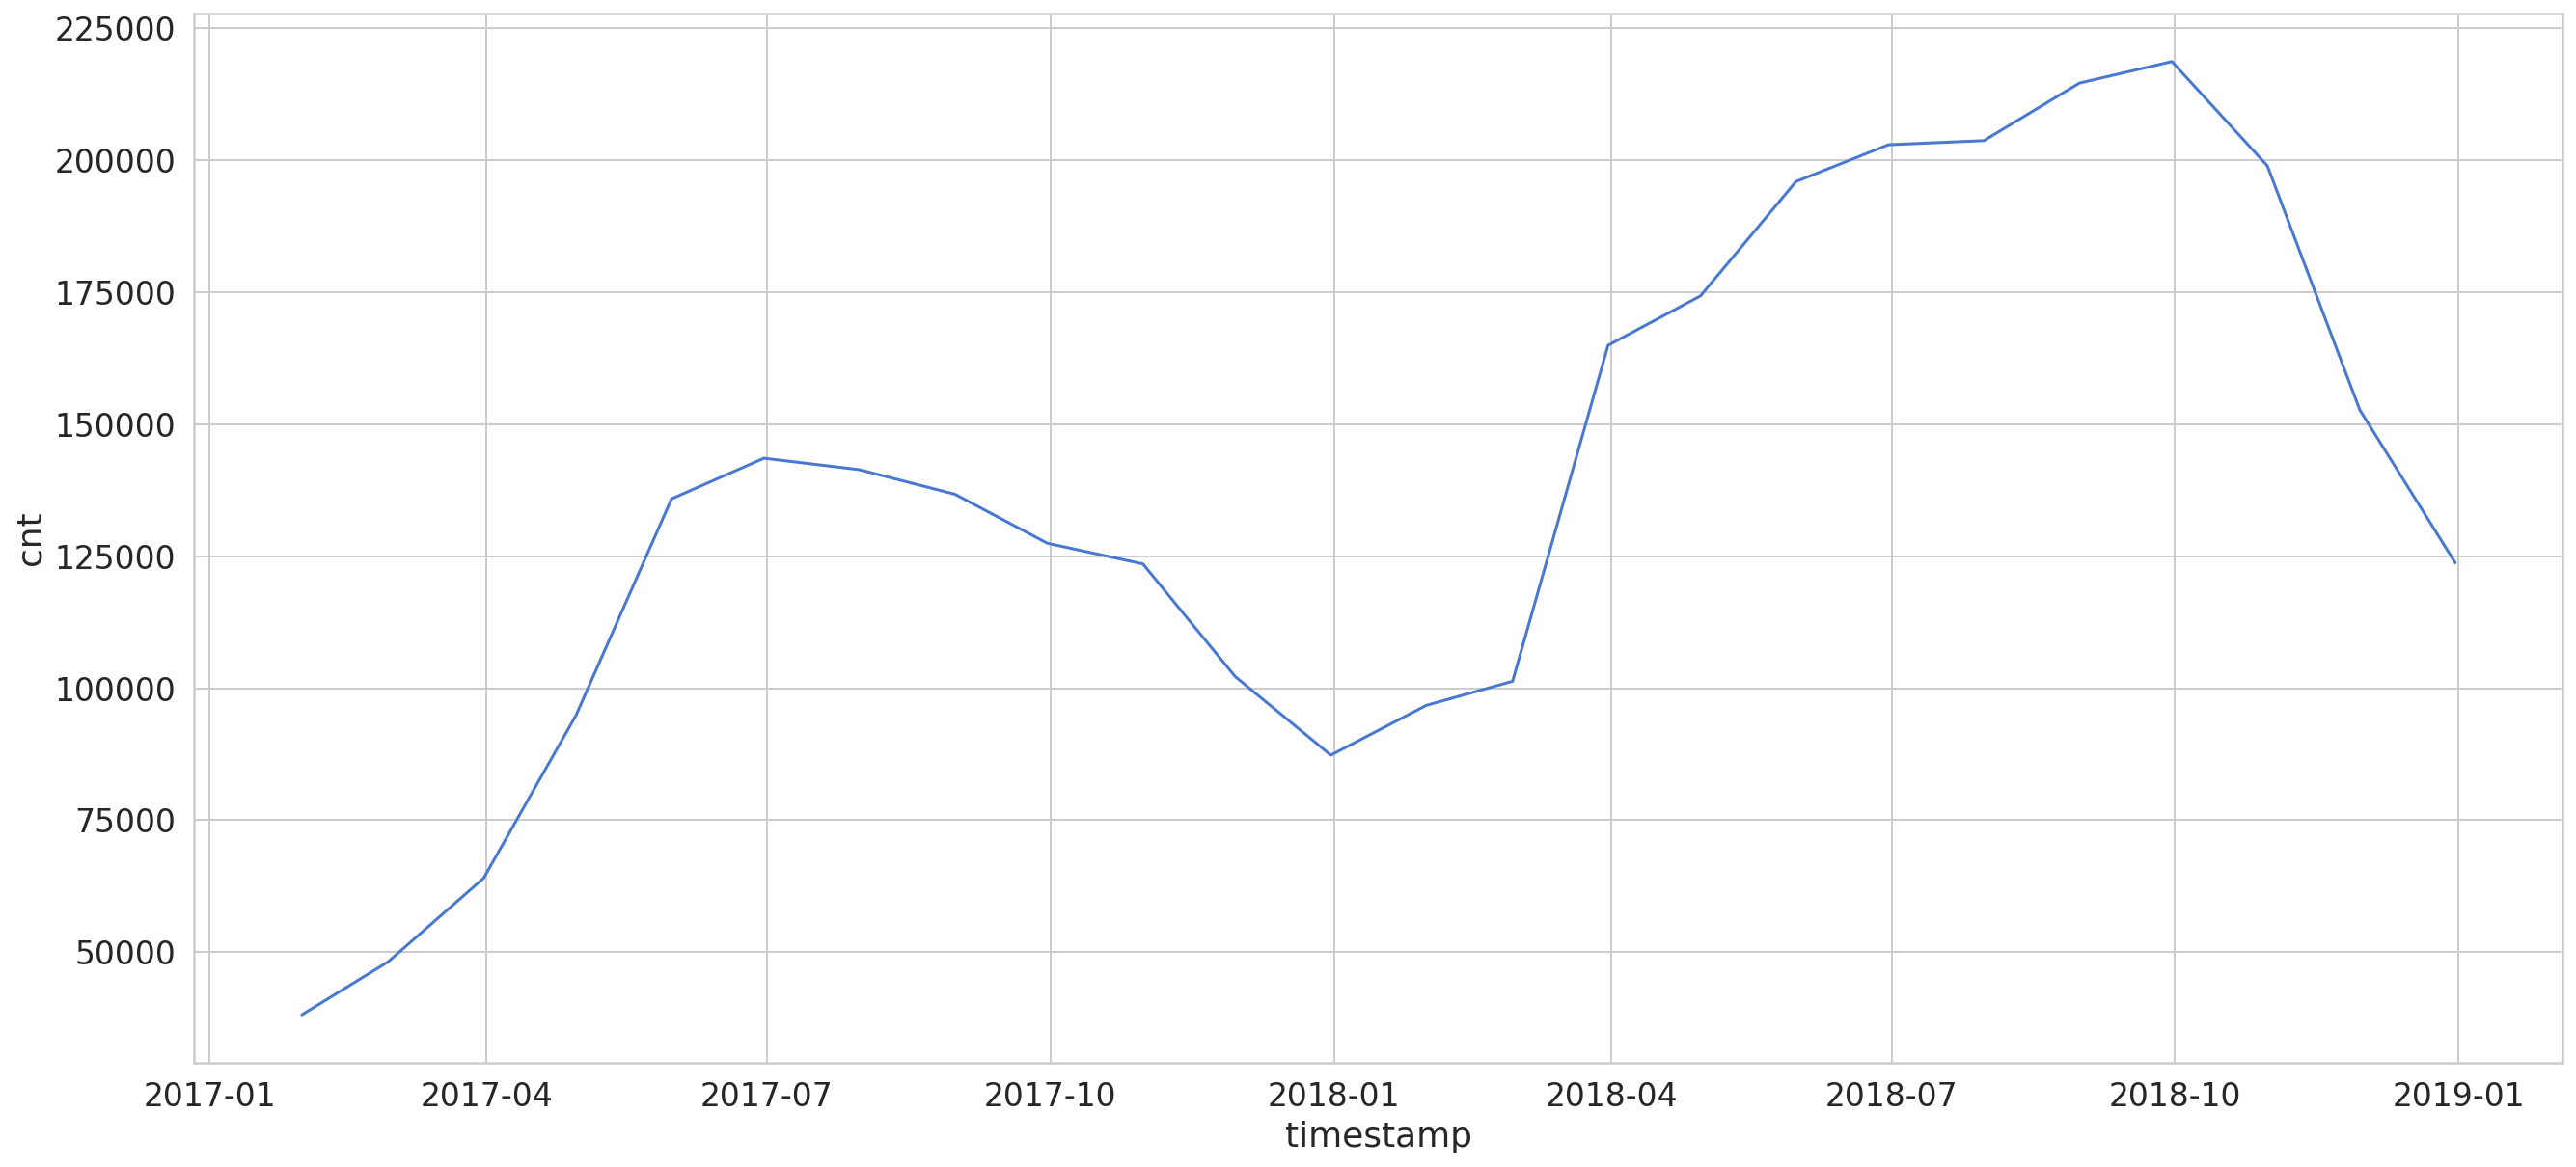

In [8]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

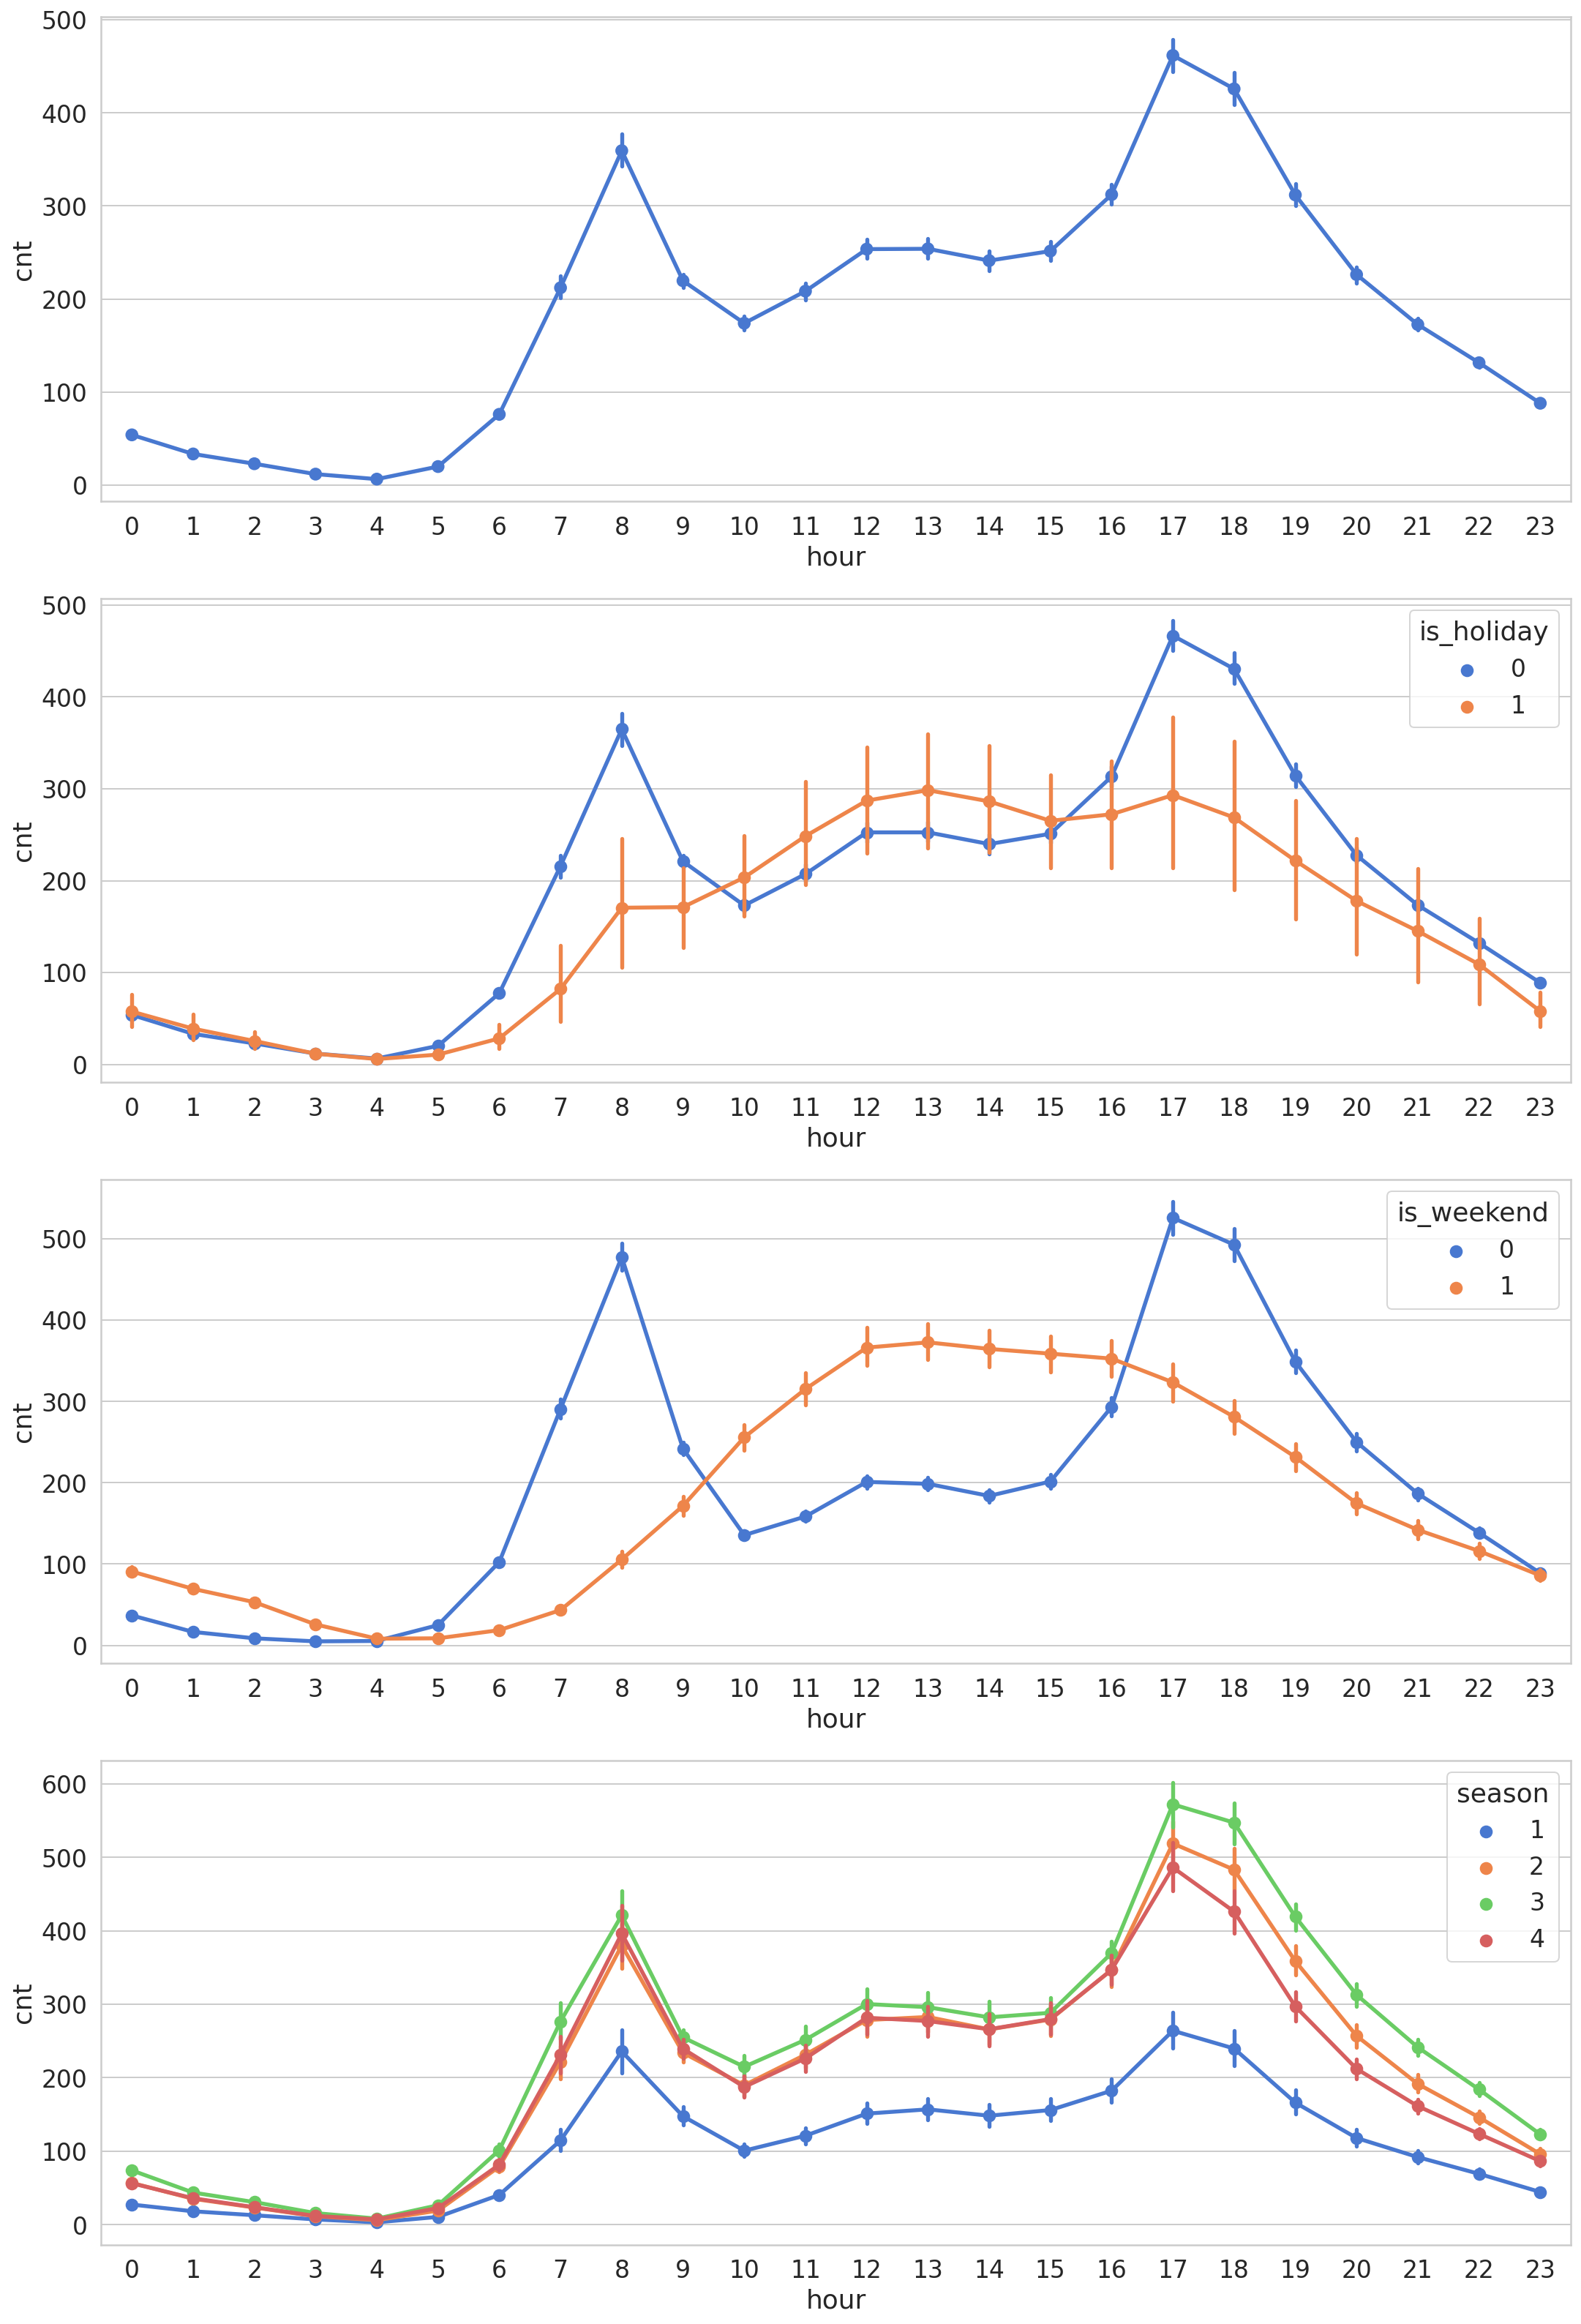

In [9]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

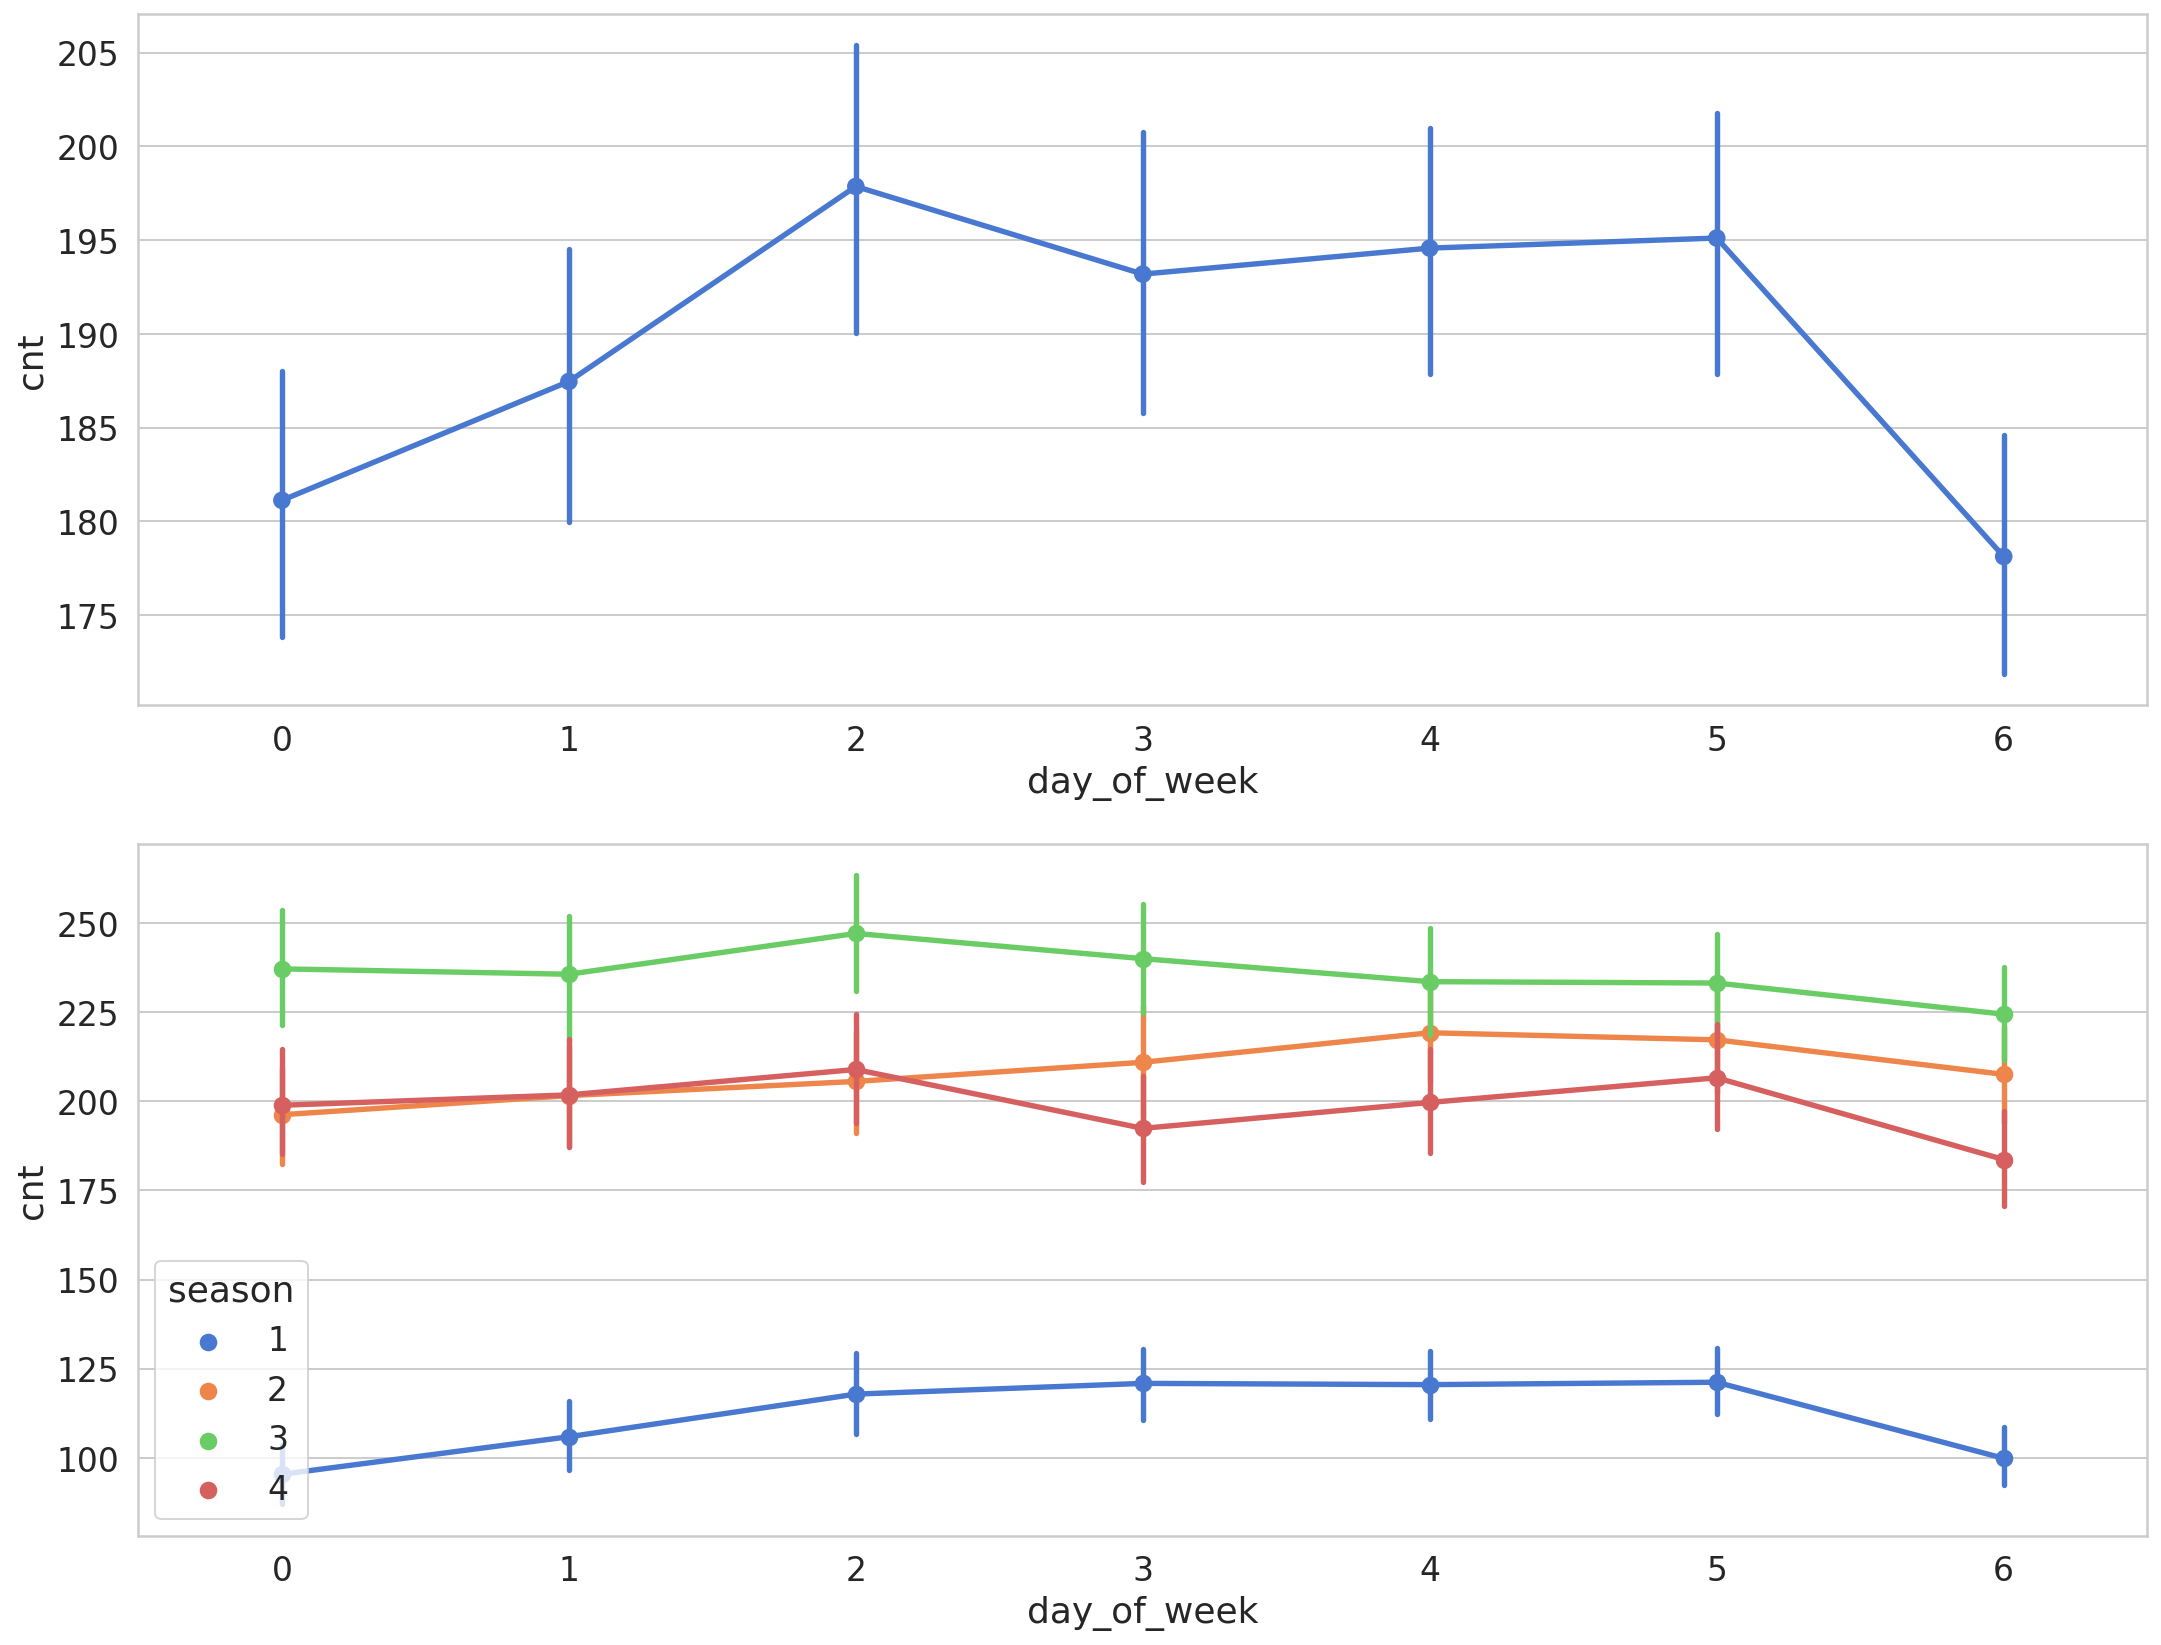

In [10]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [11]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15620 1736


# Preprocessing

In [12]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-12-92b06493bae2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [13]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15610, 10, 13) (15610,)


In [15]:
from keras import backend as K
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dense(units=1))
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer='adam')
K.set_value(model.optimizer.learning_rate, 0.001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=16, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/200
879/879 [==============================] - 24s 21ms/step - loss: 0.1314 - val_loss: 0.1444
Epoch 2/200
879/879 [==============================] - 17s 20ms/step - loss: 0.0473 - val_loss: 0.0818
Epoch 3/200
879/879 [==============================] - 17s 20ms/step - loss: 0.0363 - val_loss: 0.0654
Epoch 4/200
879/879 [==============================] - 17s 20ms/step - loss: 0.0322 - val_loss: 0.0592
Epoch 5/200
879/879 [==============================] - 22s 25ms/step - loss: 0.0296 - val_loss: 0.0553
Epoch 6/200
879/879 [==============================] - 19s 22ms/step - loss: 0.0280 - val_loss: 0.0563
Epoch 7/200
879/879 [==============================] - 18s 20ms/step - loss: 0.0269 - val_loss: 0.0546
Epoch 8/200
879/879 [==============================] - 18s 20ms/step - loss: 0.0257 - val_loss: 0.0523
Epoch 9/200
879/879 [==============================] - 18s 20ms/step - loss: 0.0249 - val_loss: 0.0521
Epoch 10/200
879/879 [==============================] - 17s 20ms/step - l

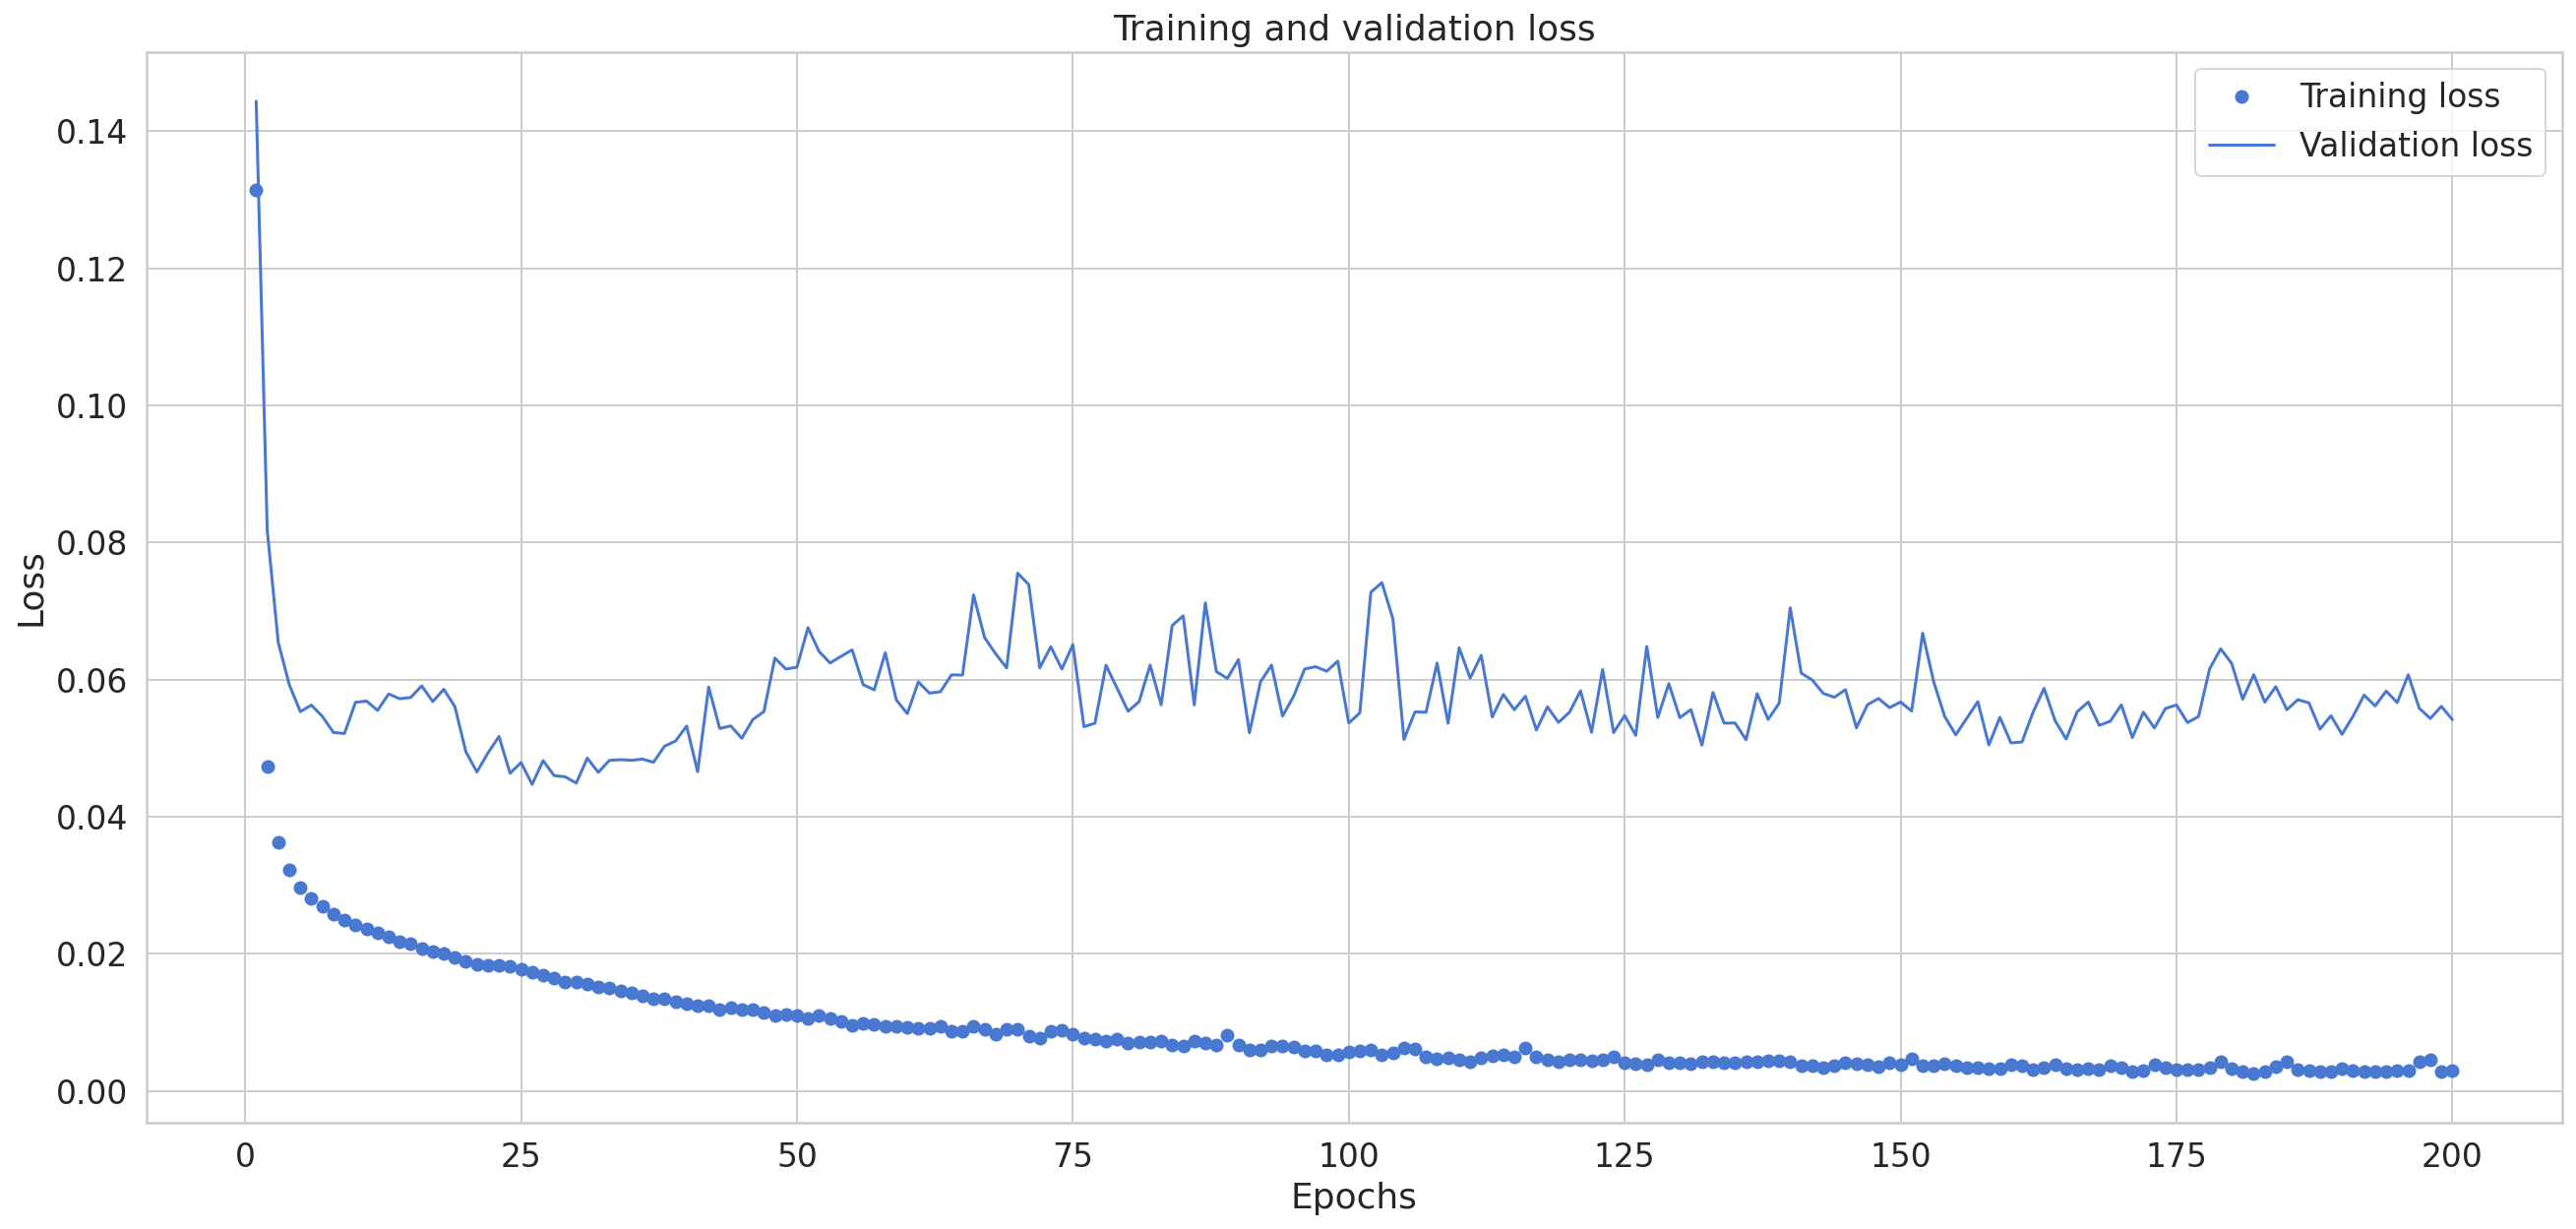

In [17]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
from keras import backend as K
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/200
440/440 [==============================] - 22s 36ms/step - loss: 0.2765 - val_loss: 0.1787
Epoch 2/200
440/440 [==============================] - 14s 33ms/step - loss: 0.0937 - val_loss: 0.1356
Epoch 3/200
440/440 [==============================] - 15s 33ms/step - loss: 0.0597 - val_loss: 0.0760
Epoch 4/200
440/440 [==============================] - 14s 33ms/step - loss: 0.0467 - val_loss: 0.0635
Epoch 5/200
440/440 [==============================] - 15s 34ms/step - loss: 0.0440 - val_loss: 0.0576
Epoch 6/200
440/440 [==============================] - 15s 33ms/step - loss: 0.0400 - val_loss: 0.0614
Epoch 7/200
440/440 [==============================] - 14s 32ms/step - loss: 0.0362 - val_loss: 0.0559
Epoch 8/200
440/440 [==============================] - 14s 32ms/step - loss: 0.0326 - val_loss: 0.0504
Epoch 9/200
440/440 [==============================] - 14s 32ms/step - loss: 0.0313 - val_loss: 0.0521
Epoch 10/200
440/440 [==============================] - 14s 32ms/step - l

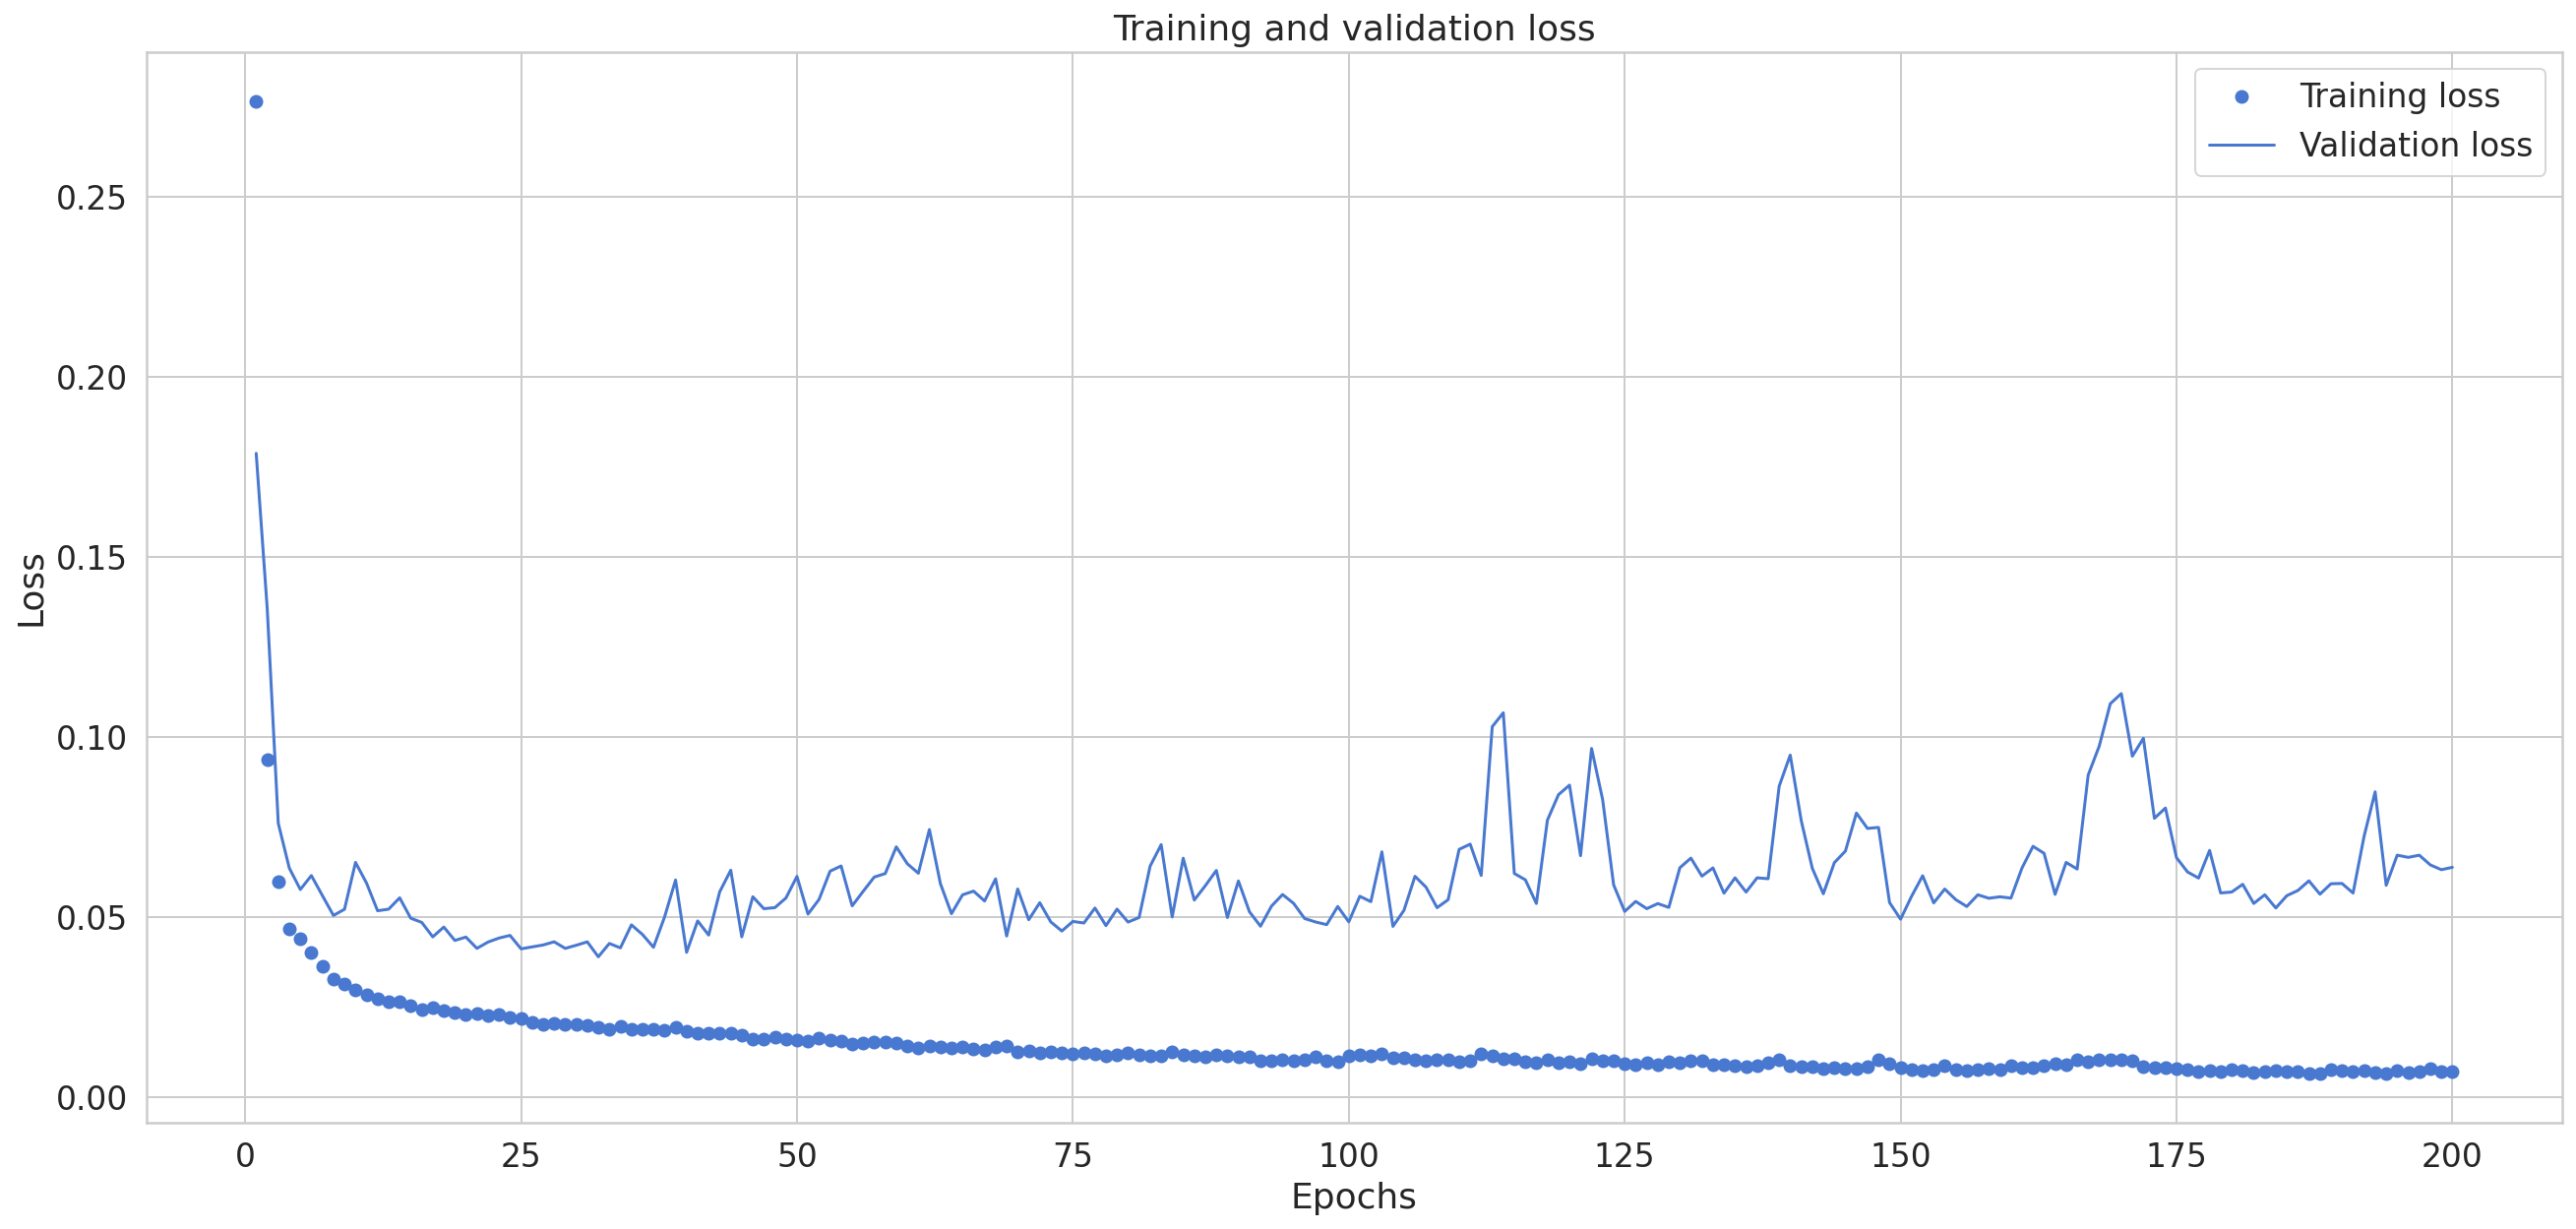

In [20]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
y_pred = model.predict(X_test)

54/54 [==============================] - 2s 11ms/step


In [22]:
train_mse = model.evaluate(X_train, y_train)
test_mse = model.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

54/54 [==============================] - 1s 12ms/step - loss: 0.0499
Train set MSE =  0.03795494884252548
Test set MSE =  0.04994972422719002


In [23]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

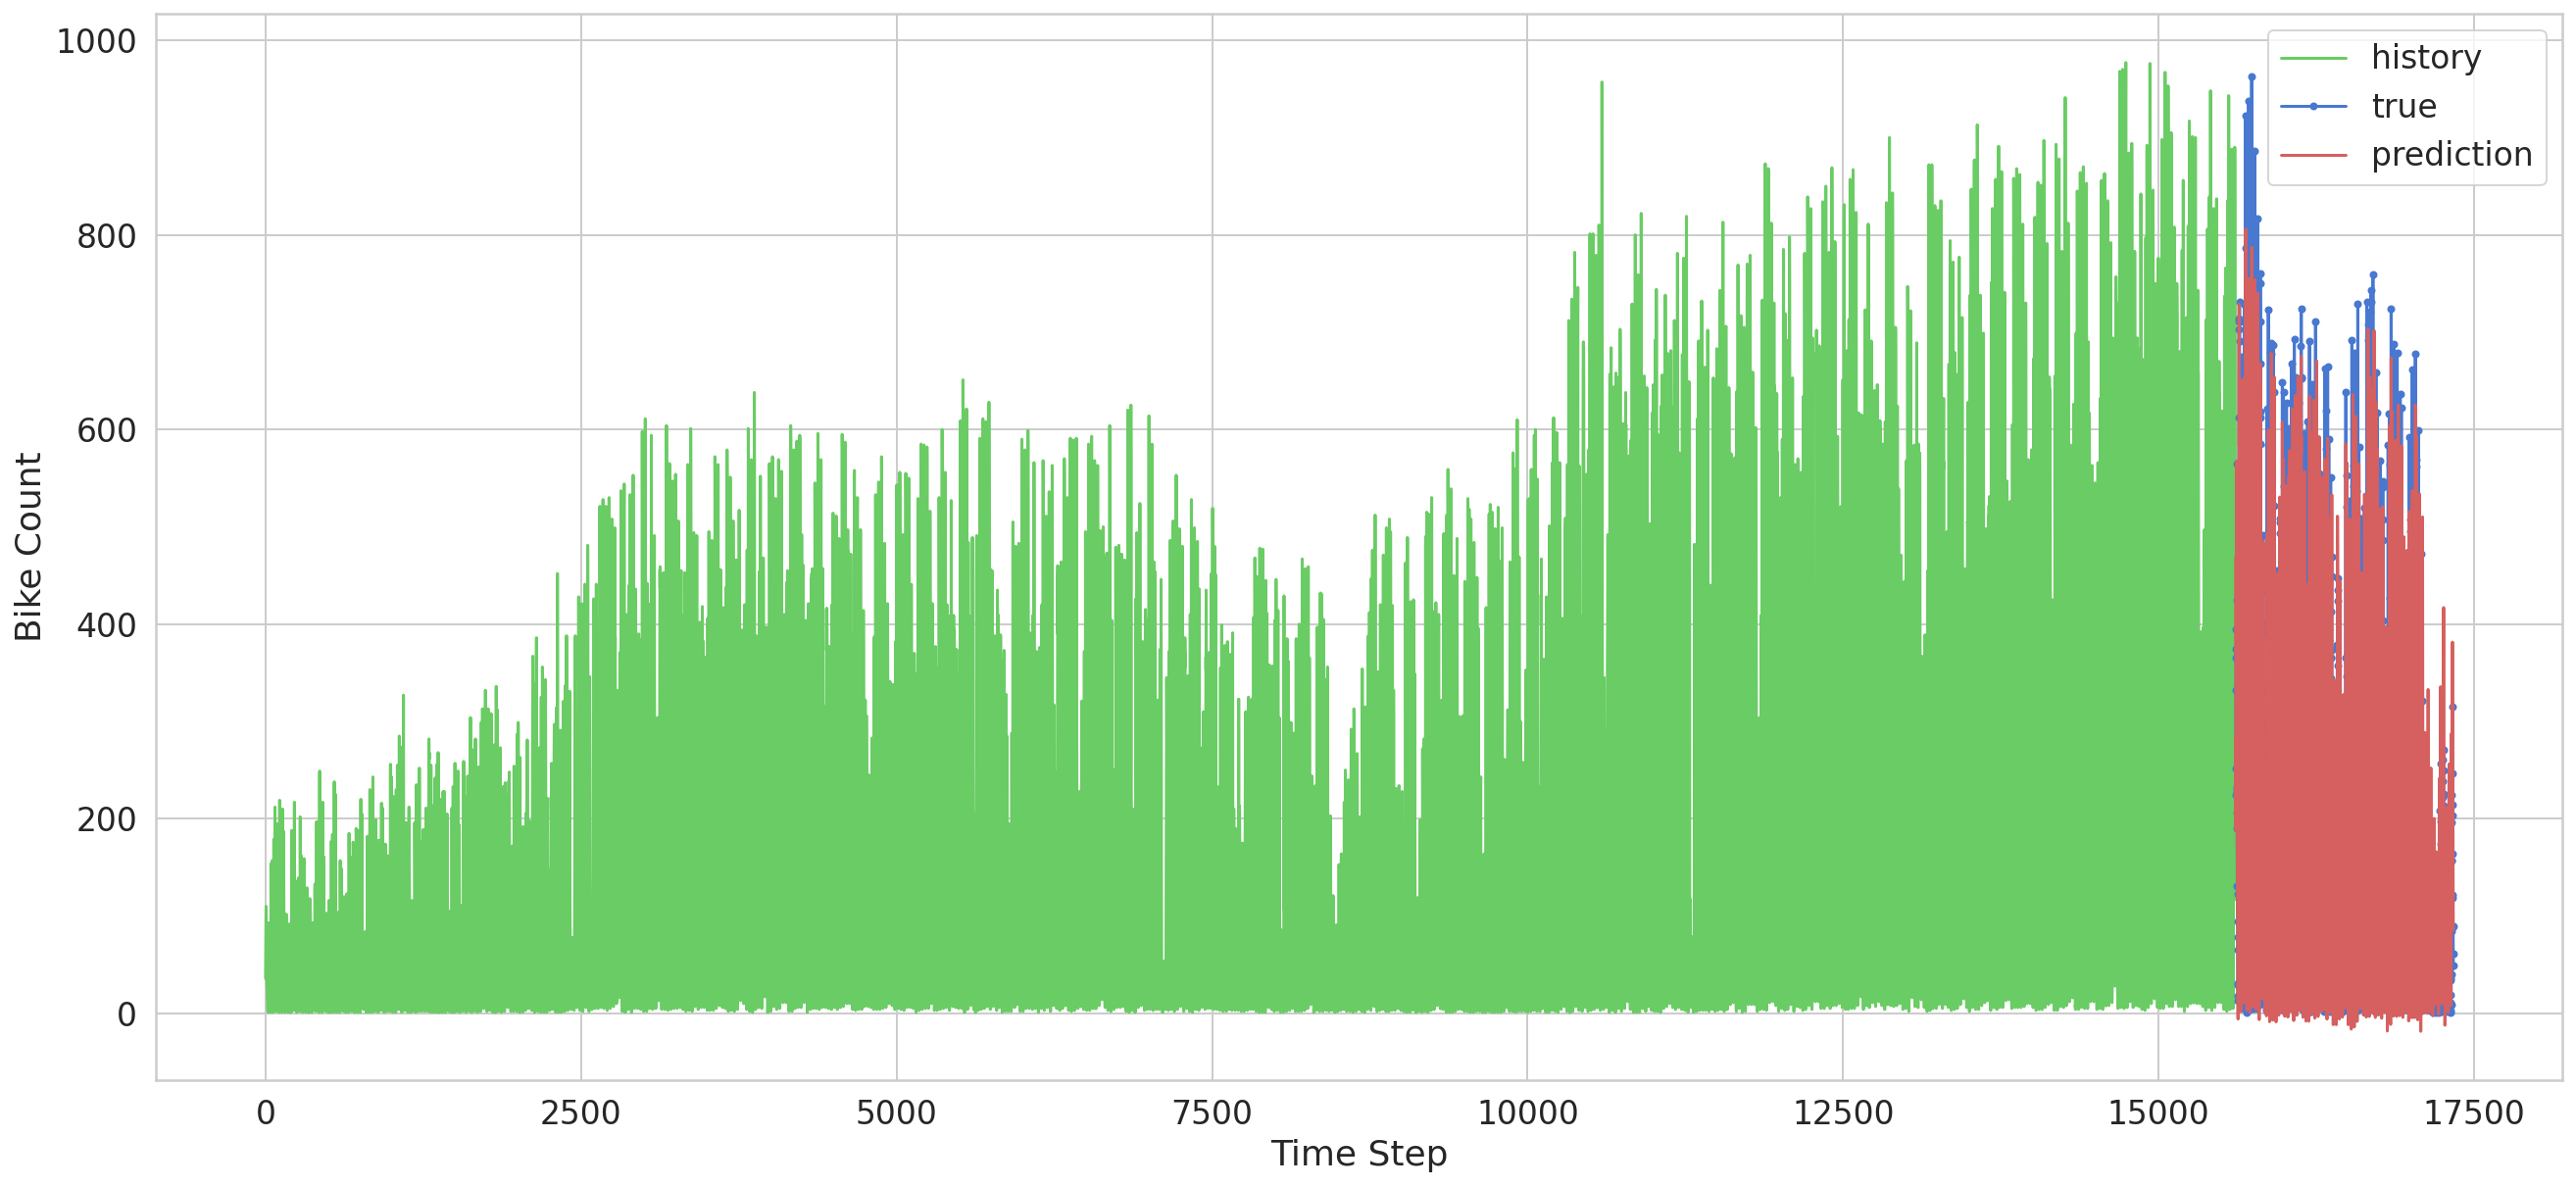

In [24]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

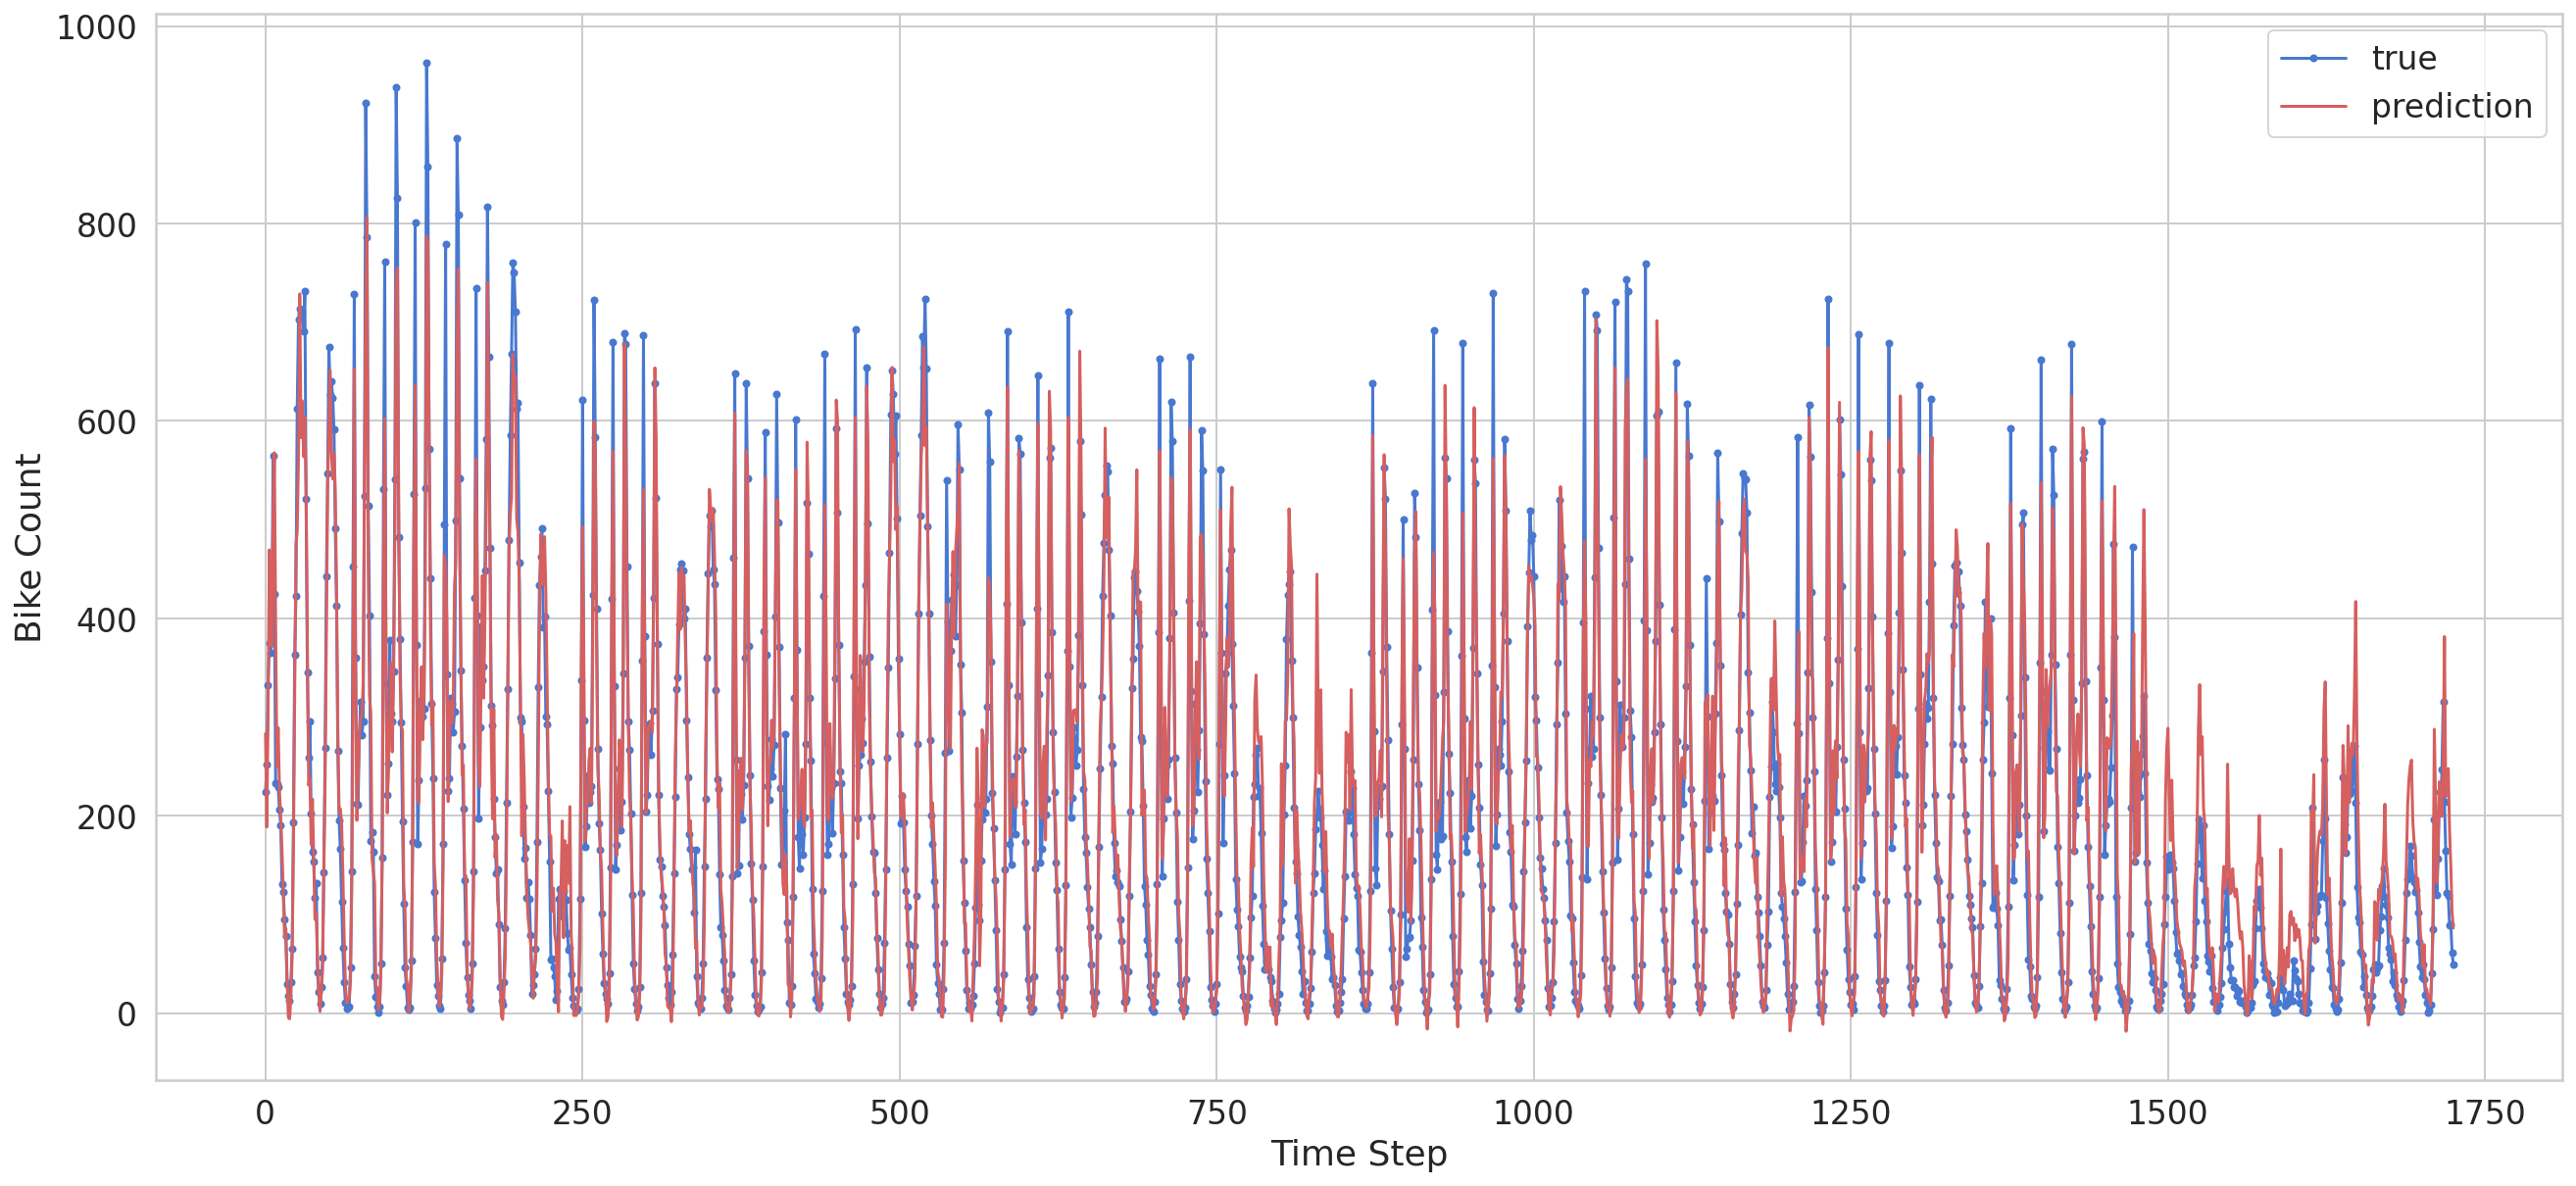

In [25]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [26]:
model = Sequential([
      #Bidirectional(LSTM(units=100,input_shape=(None, 2), return_sequences=True)),              
      LSTM(units=100,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
      Dropout(0.2),
      LSTM(units=100,return_sequences=True),
      LSTM(units=50,return_sequences=True),
      Dropout(0.2),
      Attention(),
      Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')

In [27]:
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/200
879/879 [==============================] - 36s 33ms/step - loss: 0.1840 - val_loss: 0.4409
Epoch 2/200
879/879 [==============================] - 26s 30ms/step - loss: 0.1202 - val_loss: 0.1951
Epoch 3/200
879/879 [==============================] - 26s 30ms/step - loss: 0.1025 - val_loss: 0.1778
Epoch 4/200
879/879 [==============================] - 26s 29ms/step - loss: 0.0808 - val_loss: 0.1289
Epoch 5/200
879/879 [==============================] - 26s 29ms/step - loss: 0.0653 - val_loss: 0.1452
Epoch 6/200
879/879 [==============================] - 26s 29ms/step - loss: 0.0538 - val_loss: 0.0826
Epoch 7/200
879/879 [==============================] - 25s 29ms/step - loss: 0.0444 - val_loss: 0.0822
Epoch 8/200
879/879 [==============================] - 27s 30ms/step - loss: 0.0413 - val_loss: 0.0793
Epoch 9/200
879/879 [==============================] - 25s 29ms/step - loss: 0.0382 - val_loss: 0.0690
Epoch 10/200
879/879 [==============================] - 25s 29ms/step - l

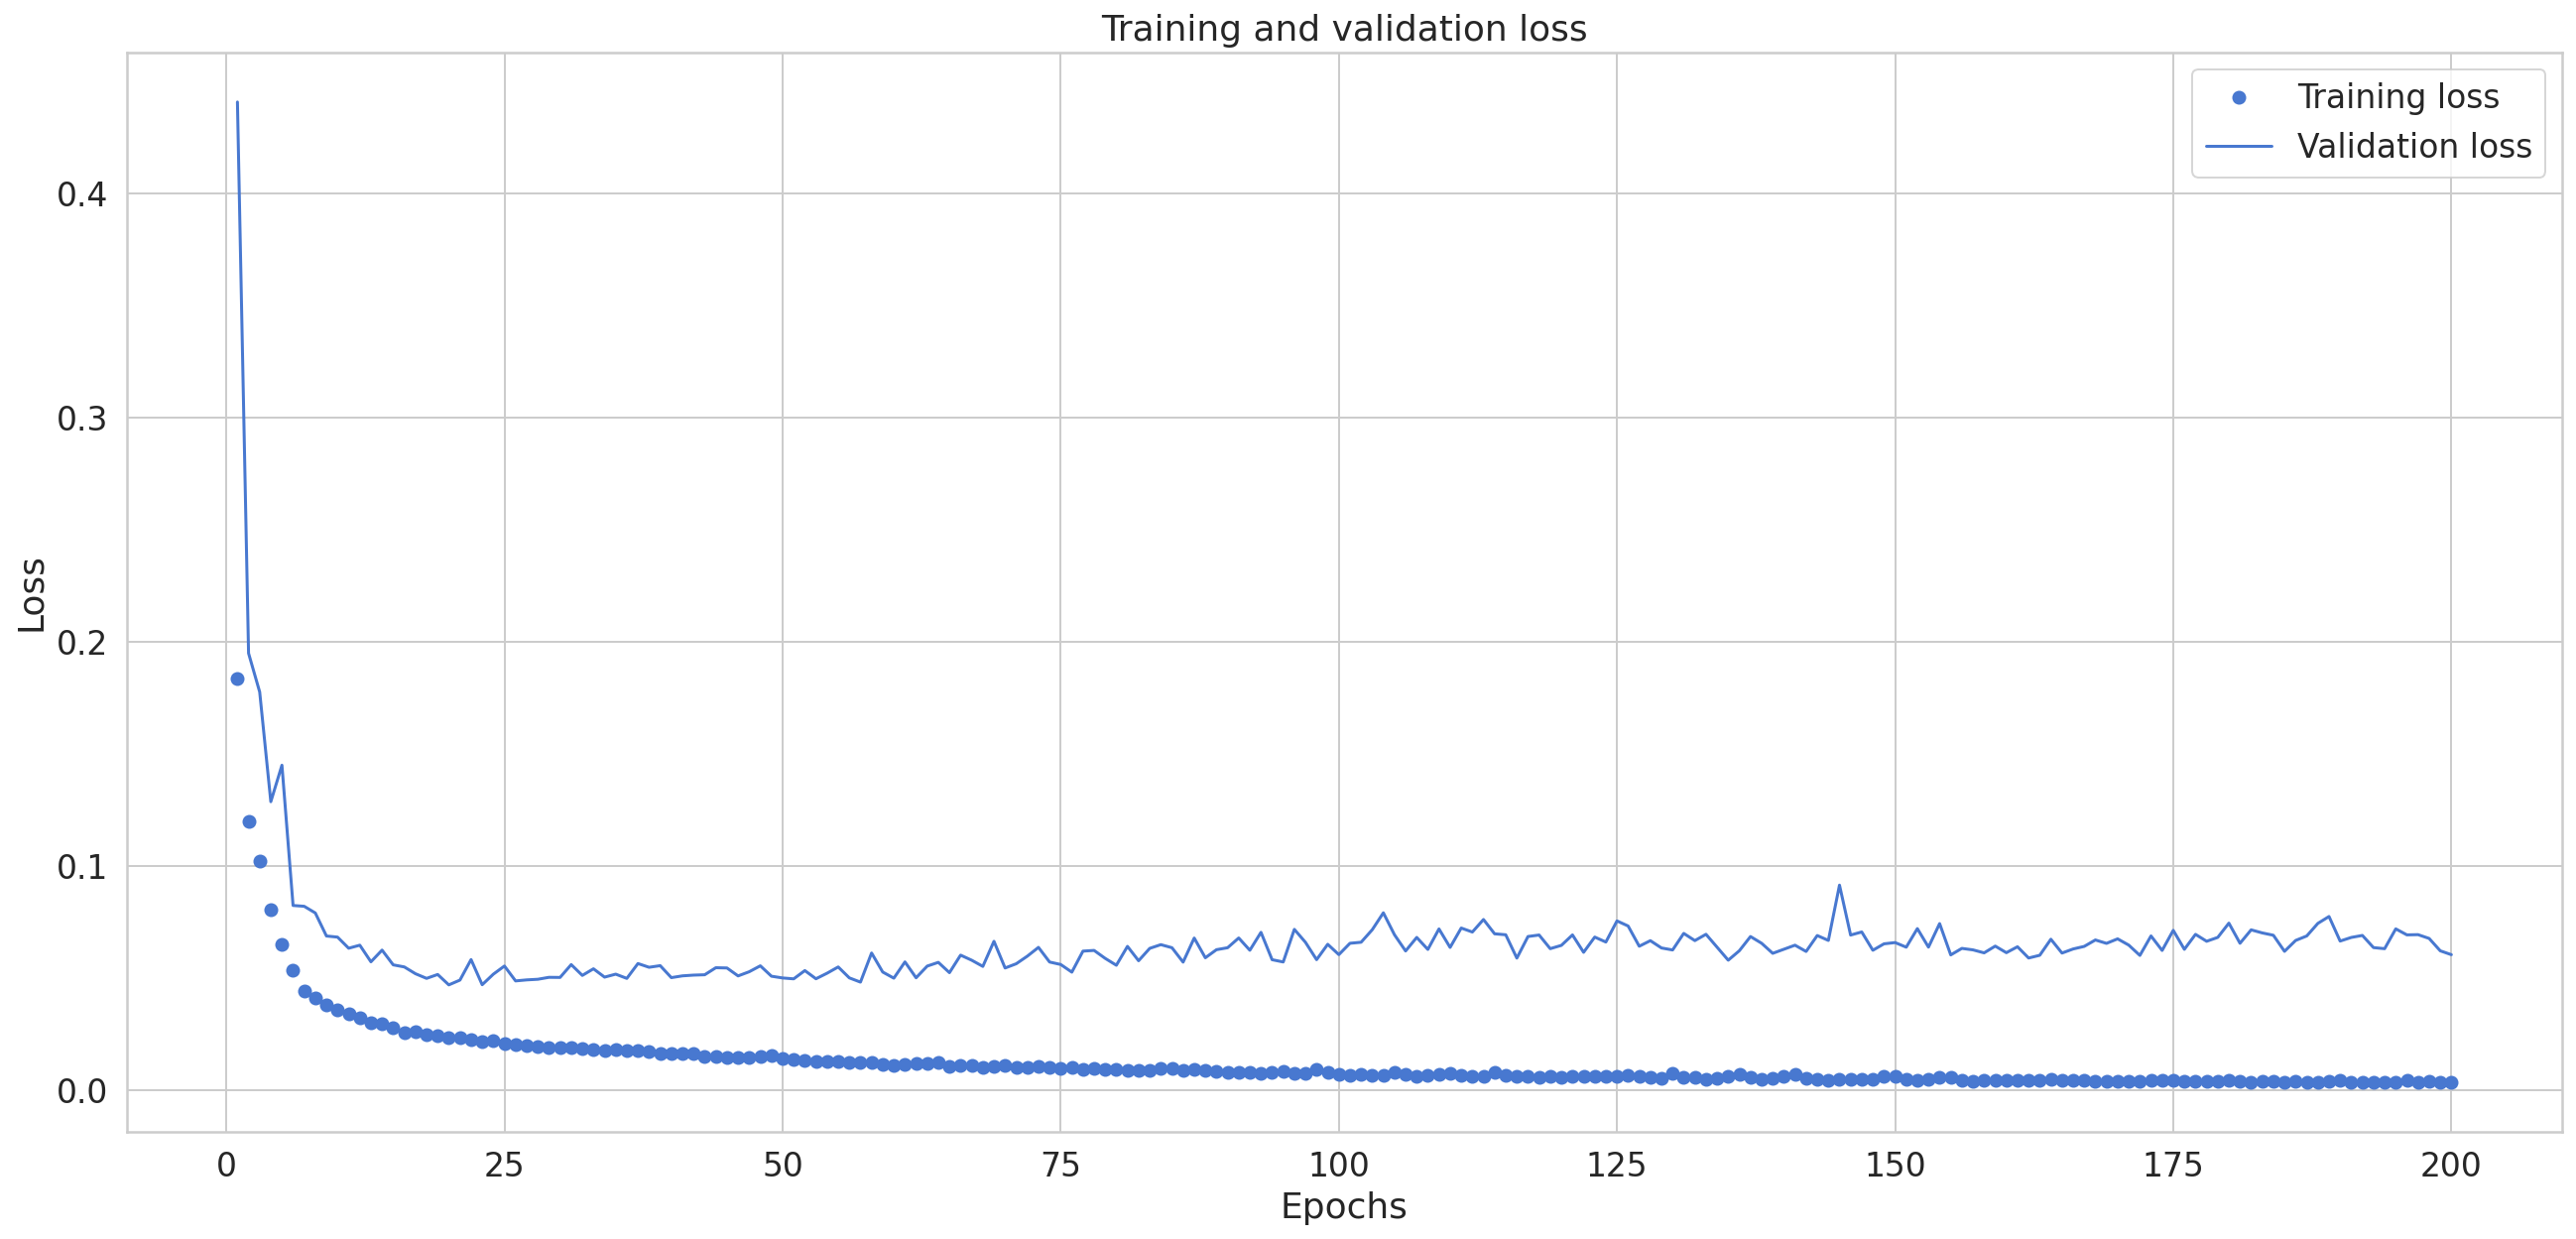

In [28]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
y_pred = model.predict(X_test)

54/54 [==============================] - 4s 12ms/step


In [30]:
train_mse = model.evaluate(X_train, y_train)
test_mse = model.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

54/54 [==============================] - 1s 11ms/step - loss: 0.0491
Train set MSE =  0.02390124835073948
Test set MSE =  0.049110546708106995


In [31]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

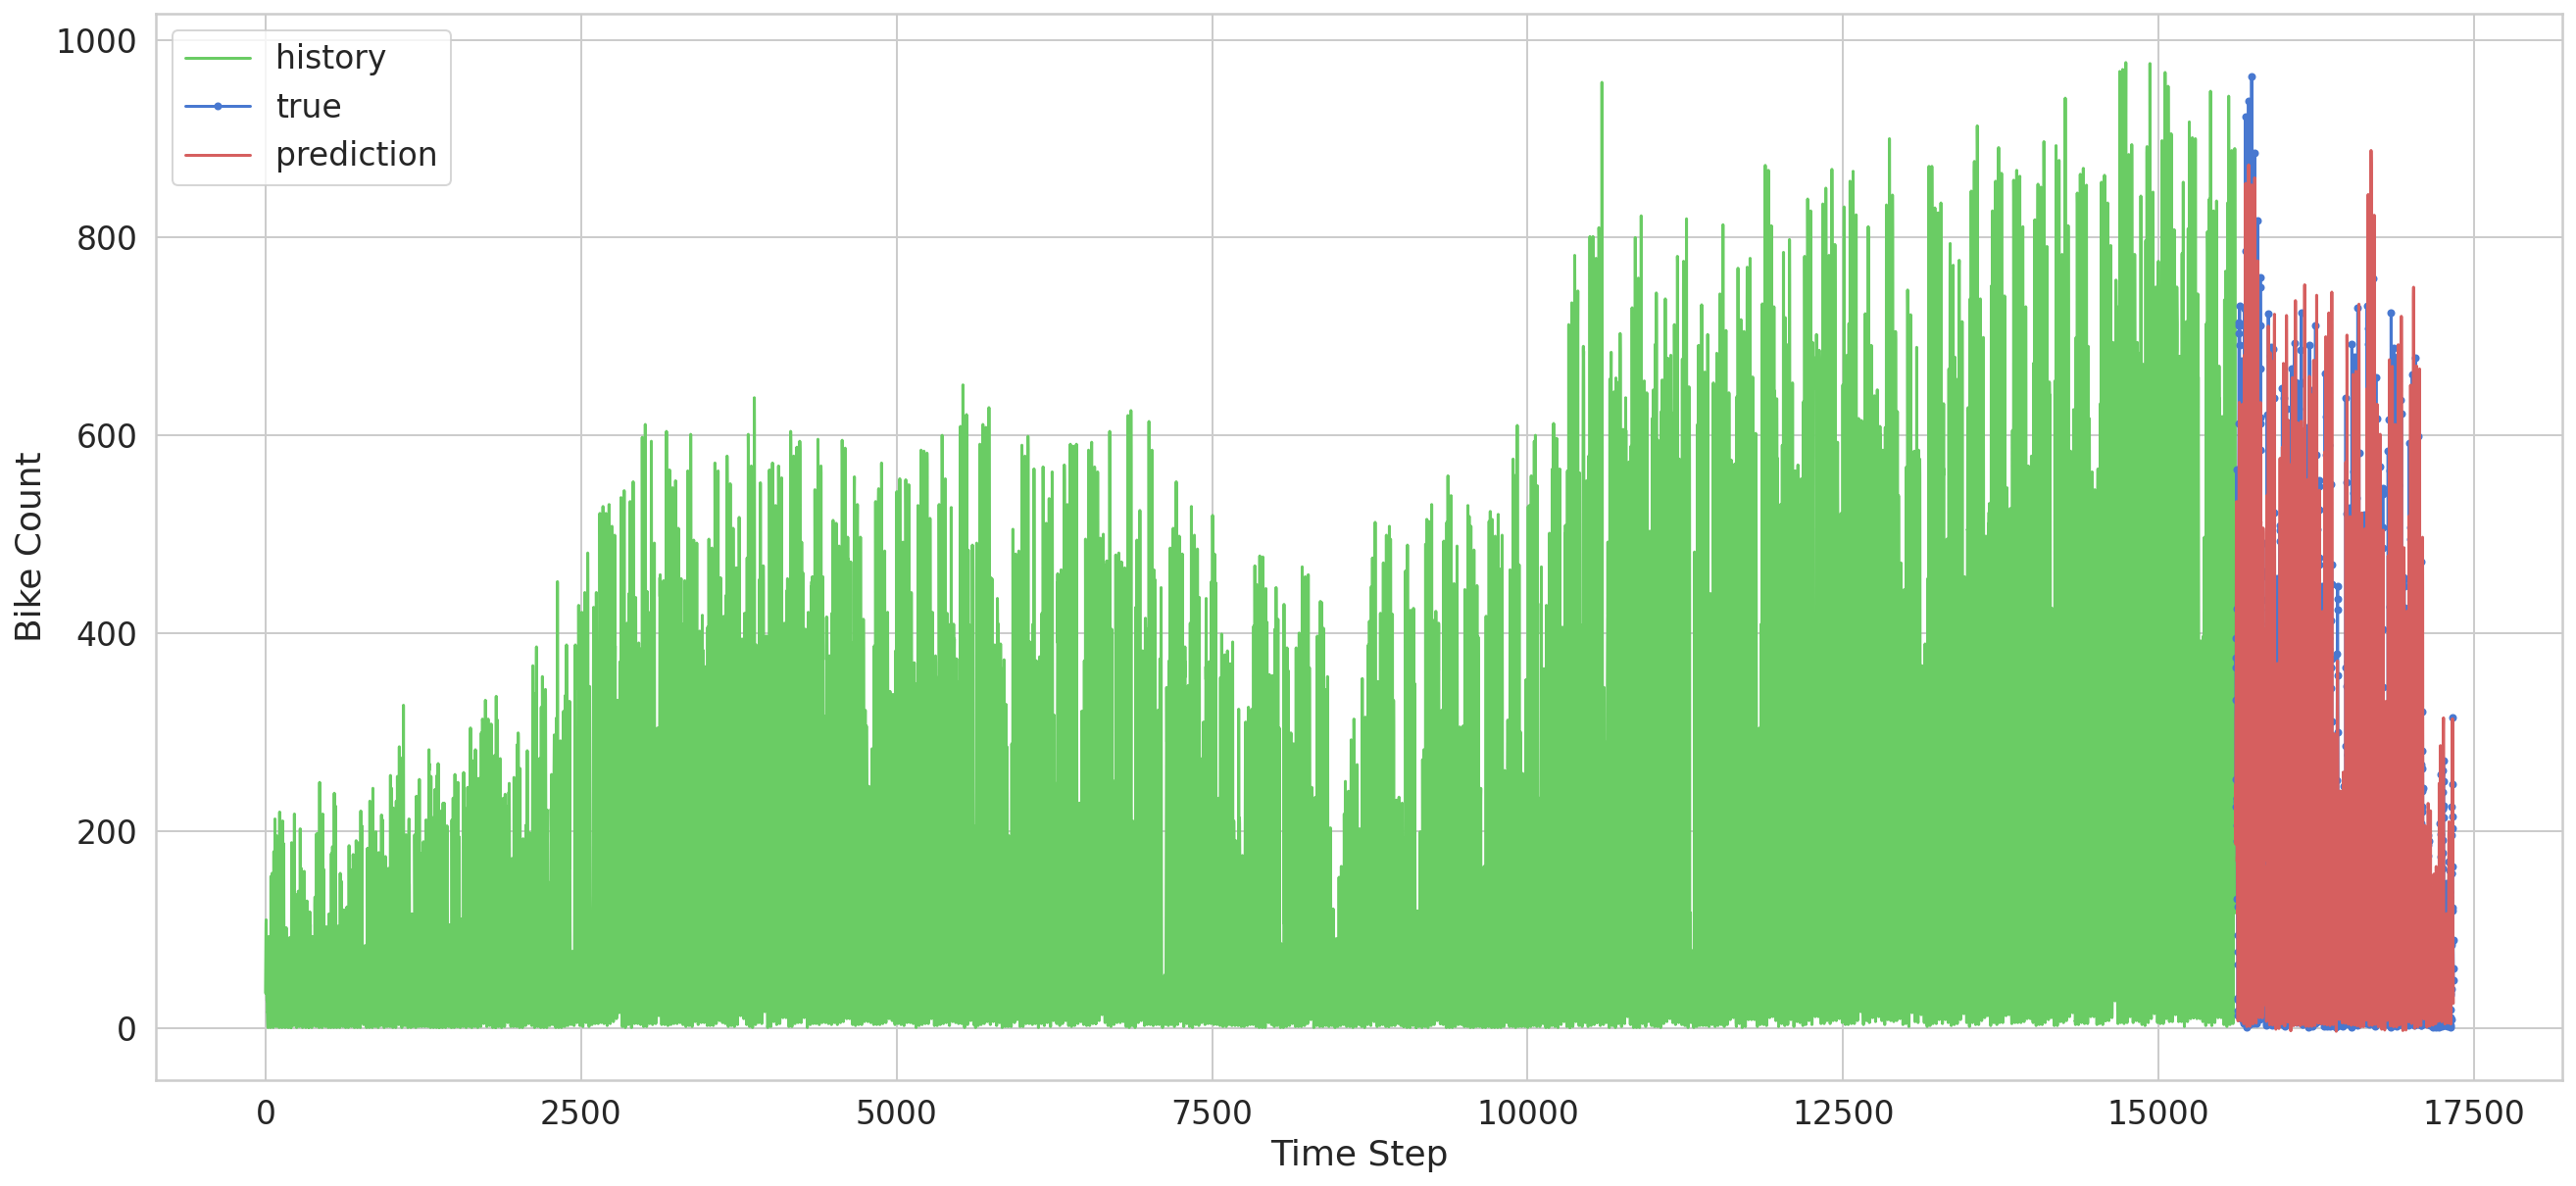

In [32]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

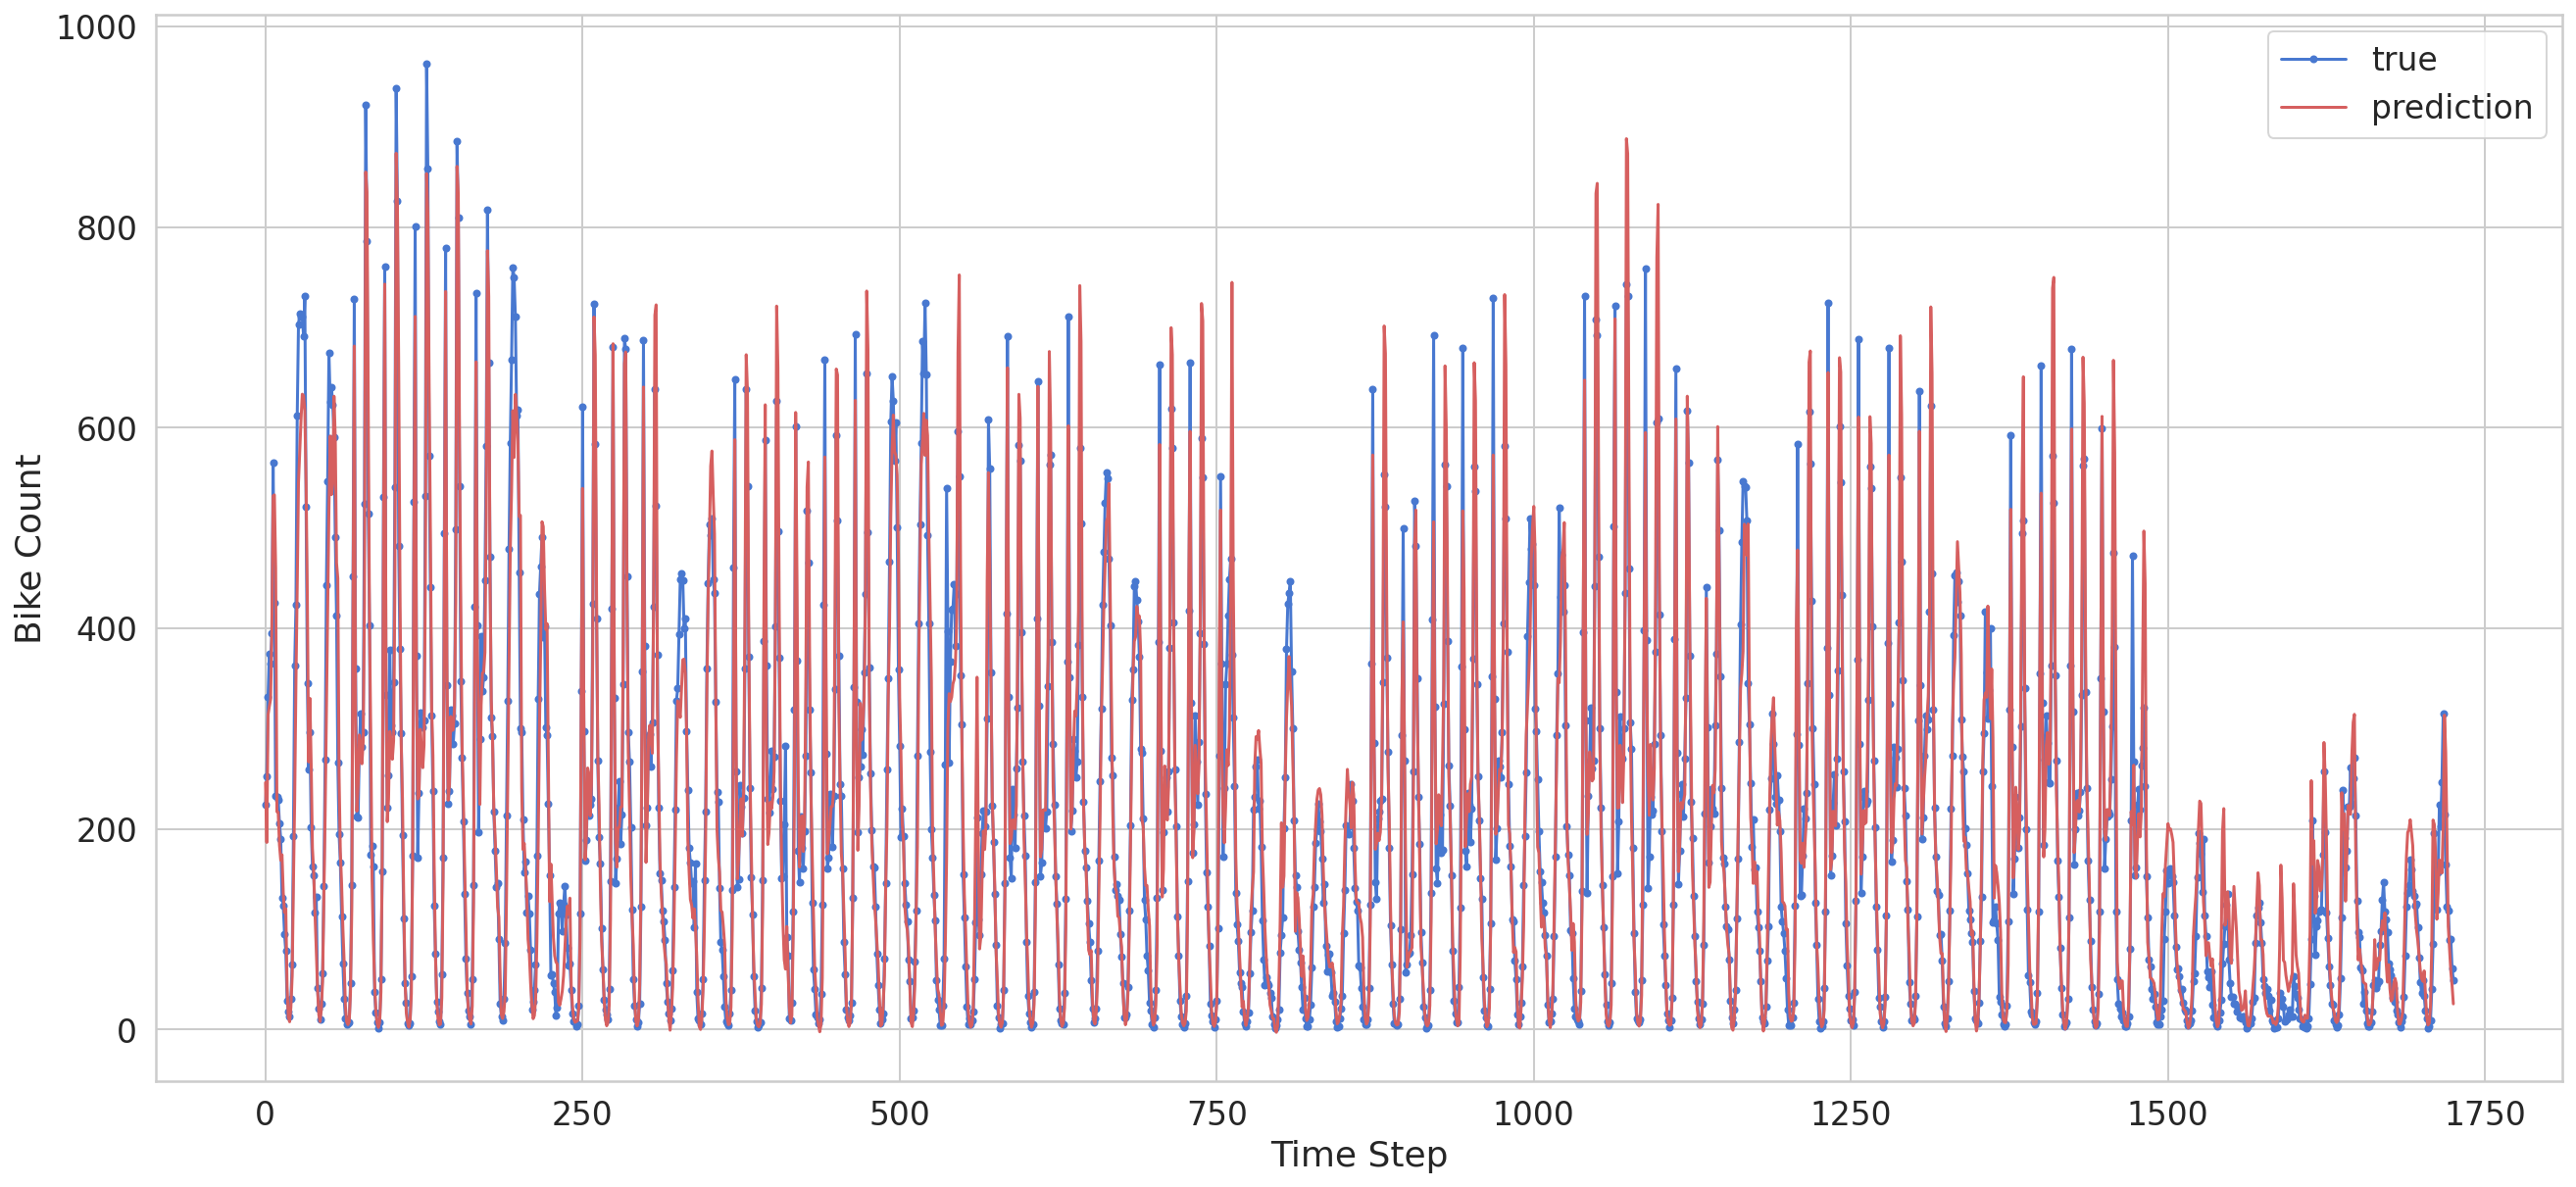

In [33]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();